# Model Tuning Project: ReneWind

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.). 



## Objective
“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 40000 observations in the training set and 10000 in the test set.

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generator could be repaired before failing/breaking to reduce the maintenance cost. The different costs associated with maintenance are as follows:

- Replacement cost = 40,000 dollars
- Repair cost = 15,000 dollars
- Inspection cost = 5,000 dollars

“1” in the target variables should be considered as “failure” and “0” will represent “No failure”.

## Data Description
- The data provided is a transformed version of original data which was collected using sensors.
- Train.csv - To be used for training and tuning of models. 
- Test.csv - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable

## Importing libraries

In [1]:
# To help with reading and manipulating data
import pandas as pd
import numpy as np

# To help with data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# To be used for missing value imputation
from sklearn.impute import SimpleImputer

# To help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

# To get different metric scores, and split data
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
)

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To be used for tuning the model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)

# To supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.2f" % x)

# To supress warnings
import warnings

warnings.filterwarnings("ignore")

## Importing Data

In [2]:
# reading csv files into seperate pandas Dataframes
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

# print the shape of both Dataframes
print(train.shape)
print(test.shape)

# copying data to another varaible to preserve original training data
df_train = train.copy()
df_test = test.copy()

(40000, 41)
(10000, 41)


#### Observations
- The training and test dataframes both have 41 columns
- The training data has 40,000 observations
- The test data has 10,000 observations

## EDA

In [3]:
# print a sample of five rows randomly selected from the training data
df_train.sample(n=5)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
21103,1.52,-1.42,0.24,-1.61,-0.71,-0.95,-0.12,1.93,-0.22,0.07,0.11,1.18,2.52,1.26,-0.87,1.29,-1.53,-0.12,-1.03,0.06,-1.50,0.79,1.91,-1.17,0.18,-0.27,1.28,-1.54,-0.64,0.49,1.68,1.60,-0.47,-1.14,1.23,1.39,0.09,-3.63,-0.32,0.22,0
10406,0.29,-1.39,0.18,-0.53,-0.09,-1.24,-0.74,1.49,-0.79,0.74,-1.91,1.60,1.20,0.76,-1.67,-0.77,0.03,1.30,0.31,0.44,-2.44,1.94,2.74,2.38,-0.13,-0.57,-0.37,-0.42,-1.85,0.57,1.25,3.77,-0.49,-0.90,2.22,1.68,-0.02,-2.16,-0.15,-0.76,0
5519,-6.34,-0.98,1.47,4.72,1.82,-2.64,-1.89,1.79,-3.97,3.81,-3.89,2.20,-1.66,-0.26,-2.52,0.13,0.93,0.12,5.85,0.38,-1.12,0.08,1.59,10.57,-3.29,0.78,-6.11,1.79,-2.12,2.47,3.12,12.27,3.22,2.19,5.64,1.88,-2.18,1.37,0.56,-5.72,0
663,3.19,5.64,2.73,4.53,0.88,0.25,-1.15,-6.23,5.17,-2.12,-4.73,-5.03,-1.35,-3.09,-2.61,-11.48,4.00,1.43,1.25,0.08,-6.11,2.55,-3.16,2.40,1.94,5.03,-1.58,1.18,-3.44,-4.05,-3.14,-2.77,-1.70,-2.18,1.00,-4.03,-1.54,3.92,-0.60,-1.53,0
33027,0.82,3.35,1.91,4.94,0.45,-1.47,-1.12,-2.33,2.82,-0.91,-3.25,-2.19,0.78,-1.49,-3.25,-6.11,2.10,-0.55,2.60,0.65,-4.88,1.56,-0.50,3.10,-0.19,3.95,-2.89,0.55,-2.69,-1.16,-1.48,2.66,-0.33,-0.84,2.91,-3.14,-1.79,0.84,-0.77,-3.55,0


In [4]:
#print the statistical summary of the numerical columns in the training data
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
V1,39954.00,-0.29,3.45,-13.50,-2.75,-0.77,1.84,17.44
V2,39961.00,0.44,3.14,-13.21,-1.64,0.46,2.54,13.09
V3,40000.00,2.51,3.41,-11.47,0.20,2.27,4.58,18.37
V4,40000.00,-0.07,3.44,-16.02,-2.35,-0.12,2.15,13.28
V5,40000.00,-0.04,2.11,-8.61,-1.51,-0.10,1.35,9.40
V6,40000.00,-1.00,2.04,-10.23,-2.36,-1.01,0.37,7.07
V7,40000.00,-0.89,1.76,-8.21,-2.04,-0.93,0.21,8.01
V8,40000.00,-0.56,3.30,-15.66,-2.66,-0.38,1.71,11.68
V9,40000.00,-0.01,2.16,-8.60,-1.49,-0.05,1.43,8.51
V10,40000.00,-0.00,2.18,-11.00,-1.39,0.11,1.49,8.11


In [5]:
# print the data types of the columns within the datset
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      39954 non-null  float64
 1   V2      39961 non-null  float64
 2   V3      40000 non-null  float64
 3   V4      40000 non-null  float64
 4   V5      40000 non-null  float64
 5   V6      40000 non-null  float64
 6   V7      40000 non-null  float64
 7   V8      40000 non-null  float64
 8   V9      40000 non-null  float64
 9   V10     40000 non-null  float64
 10  V11     40000 non-null  float64
 11  V12     40000 non-null  float64
 12  V13     40000 non-null  float64
 13  V14     40000 non-null  float64
 14  V15     40000 non-null  float64
 15  V16     40000 non-null  float64
 16  V17     40000 non-null  float64
 17  V18     40000 non-null  float64
 18  V19     40000 non-null  float64
 19  V20     40000 non-null  float64
 20  V21     40000 non-null  float64
 21  V22     40000 non-null  float64
 22

- Only the columns 'V1' and 'V2' have missing values
- Of the 40 columns with sensor data, all of the columns are of datatype 'float64'. This is as expected, since the information from the sensors should be continuous data, both positive or negative.
- The dependent variable is of the datatype 'int64'. This is as expected, since the variable should be a binary 1 or 0, failure or no failure.

In [6]:
# checking for duplicate values
df_train.duplicated().sum()

0

- There are no duplicated values in the training data

In [7]:
# create dataset of only failures from training data
fail = df_train[df_train['Target']==1]
len(fail)

2187

In [8]:
# create dataset of only no failures from training data
no_fail = df_train[df_train['Target']==0]

In [9]:
#calculate failure rate in the training data
len(fail)/len(df_train) * 100

5.4675

- The failure rate in the training data is 5.47% of the observations.

In [10]:
# create dataset of only failures from testing data
fail_test = df_test[df_test['Target']==1]
len(fail)

2187

In [11]:
# create dataset of only no failures from training data
no_fail_test = df_test[df_test['Target']==0]

In [12]:
#calculate the failure rate in the testing data
len(fail_test)/len(df_test) * 100

5.47

- The failure rate in the testing data is 5.47% of the observations. 
- Therefore, we've confirmed that the failure rate for generators is the same in both datasets.

In [13]:
diff = fail.describe().T['mean'] - no_fail.describe().T['mean']
print(diff.sort_values().head())
print(" ")
print(diff.sort_values().tail())

V36   -3.69
V18   -3.32
V3    -3.25
V26   -2.74
V31   -2.24
Name: mean, dtype: float64
 
V34   2.20
V11   2.62
V15   3.64
V21   3.97
V16   4.20
Name: mean, dtype: float64


- Failed generators show the largets differences in means of observations (both lower and higher) amongst the sensors shown above
- ReneWind may find some value in conducting a root cause analysis on these sensors to further reduce the failure rate in their generators

In [14]:
diff_std = fail.describe().T['std'] - no_fail.describe().T['std']
print(diff_std.sort_values().head())
print(" ")
print(diff_std.sort_values().tail())

V36   -0.93
V38   -0.58
V8    -0.53
V27   -0.52
V20   -0.36
Name: std, dtype: float64
 
V24   1.08
V33   1.10
V13   1.25
V12   1.46
V35   1.75
Name: std, dtype: float64


- Failed generators show the largets differences in standard deviation of observations (both lower and higher) amongst the sensors shown above.
- As above, ReneWind may find some value in conducting a root cause analysis on these sensors to further reduce the failure rate in their generators

### Plotting histograms and boxplots for all the variables

In [15]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

### Plotting all the sensor values, as well as for both failures and no failures

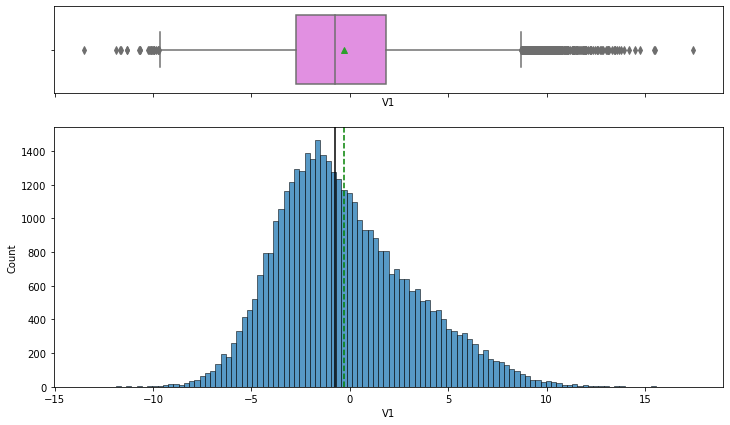

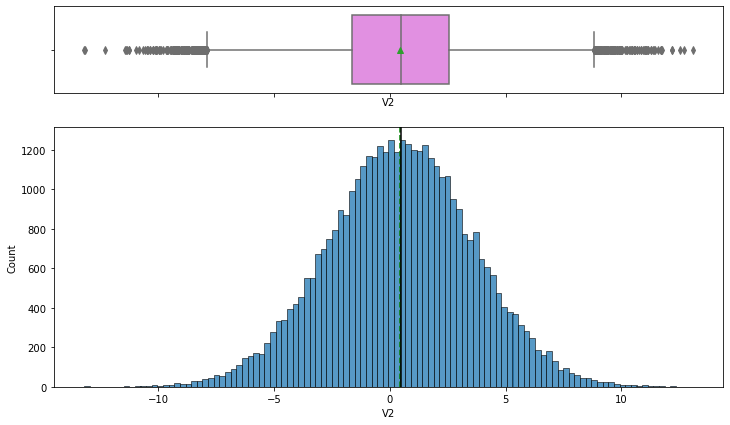

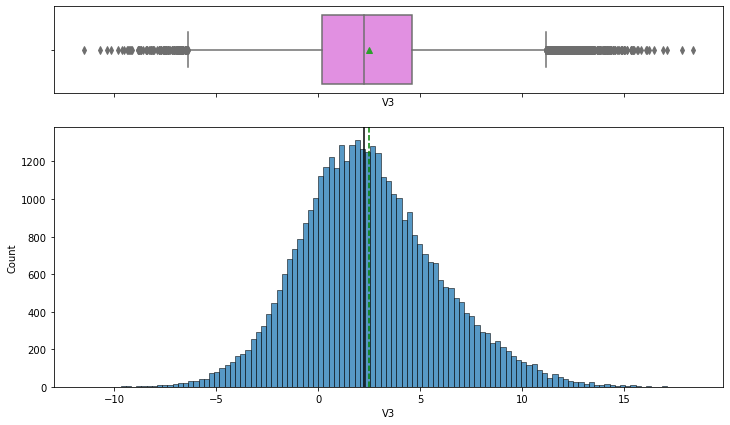

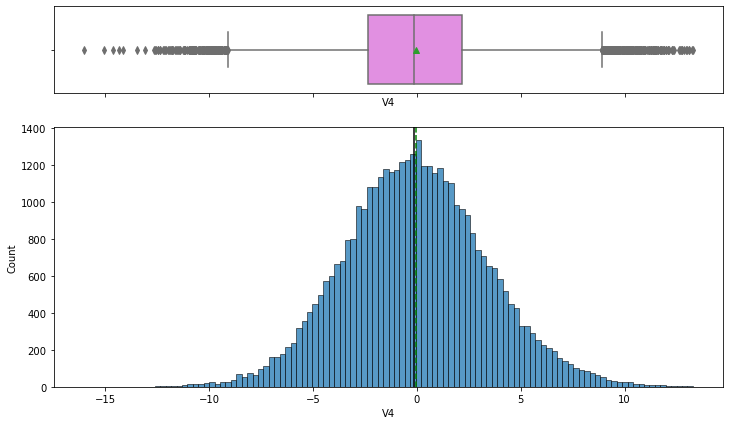

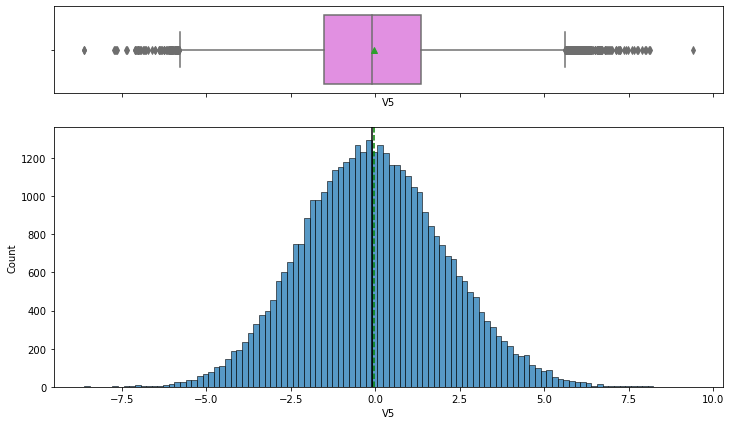

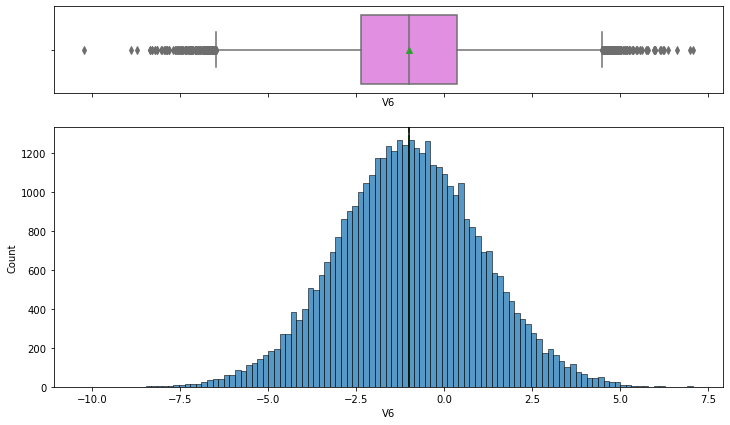

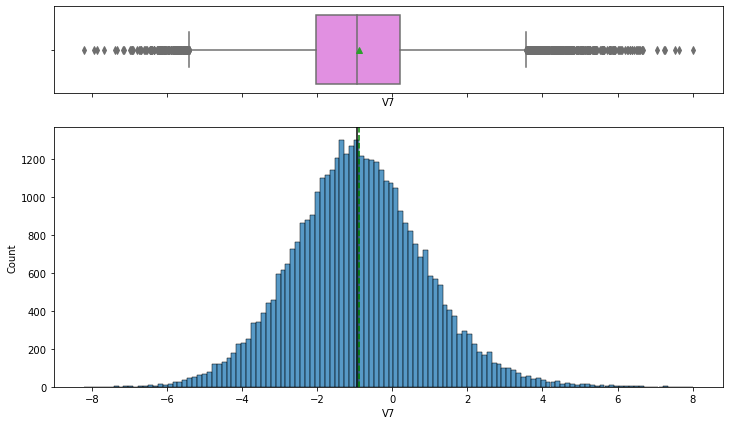

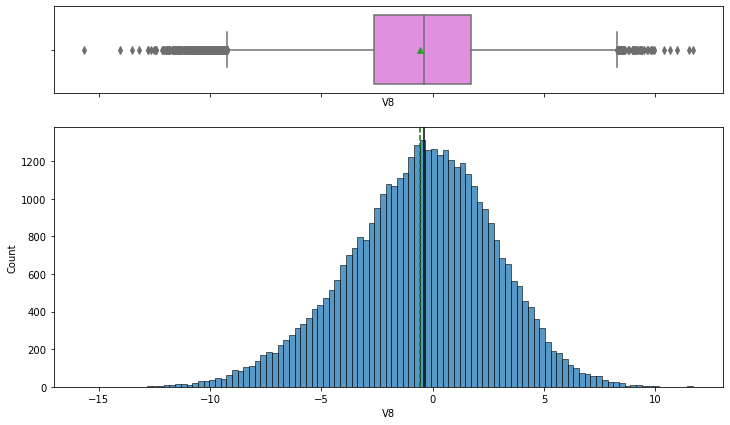

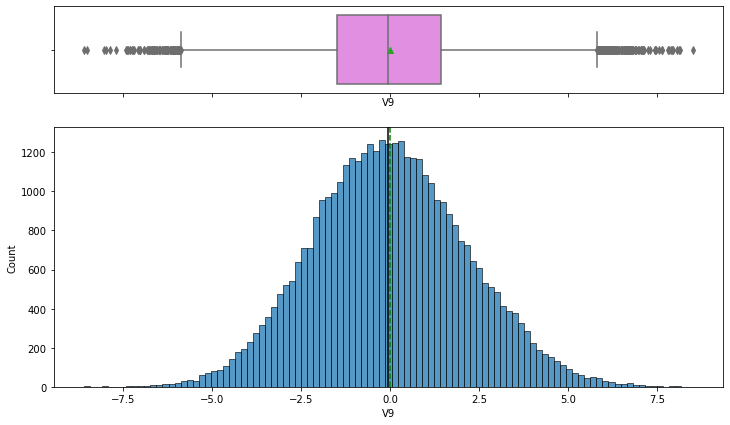

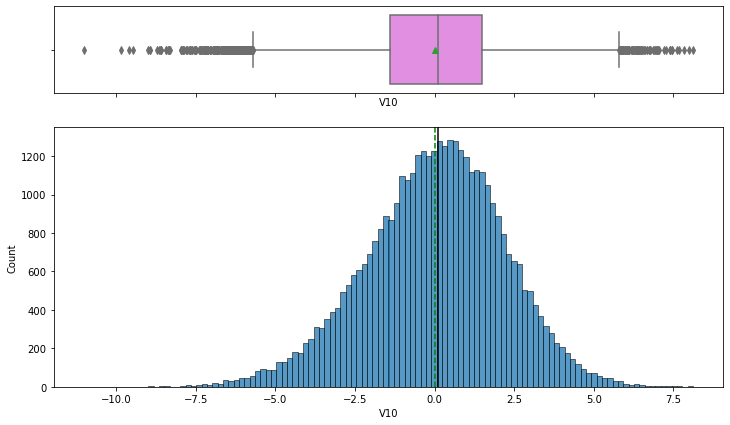

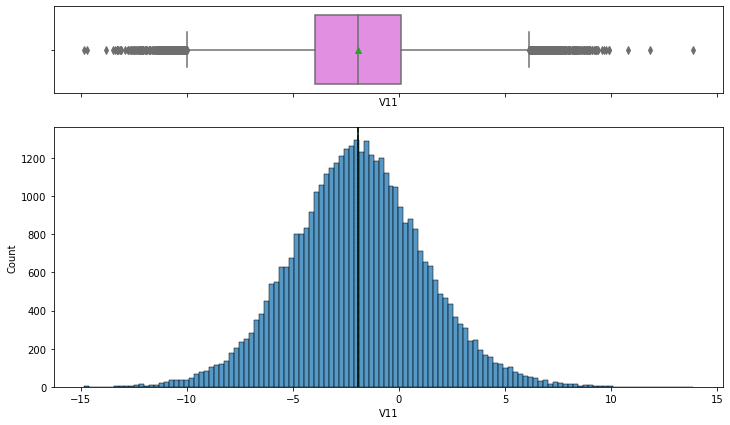

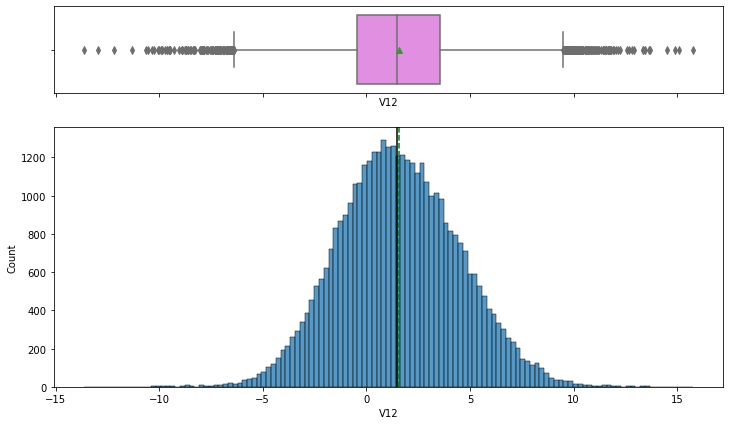

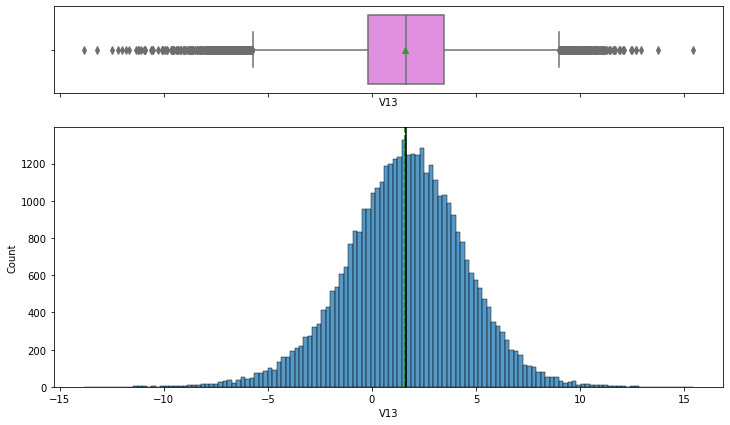

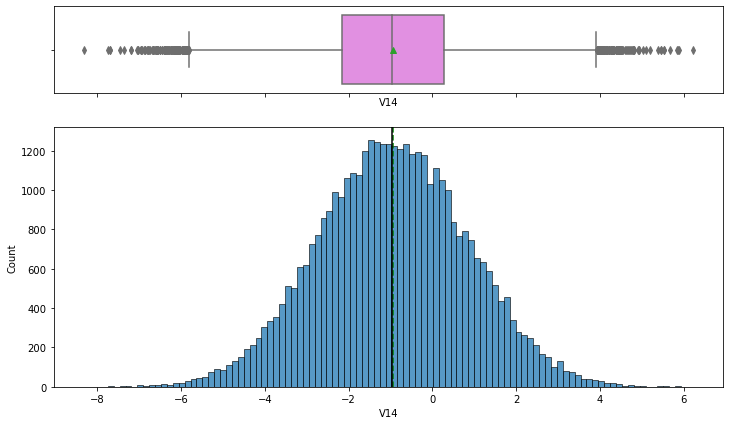

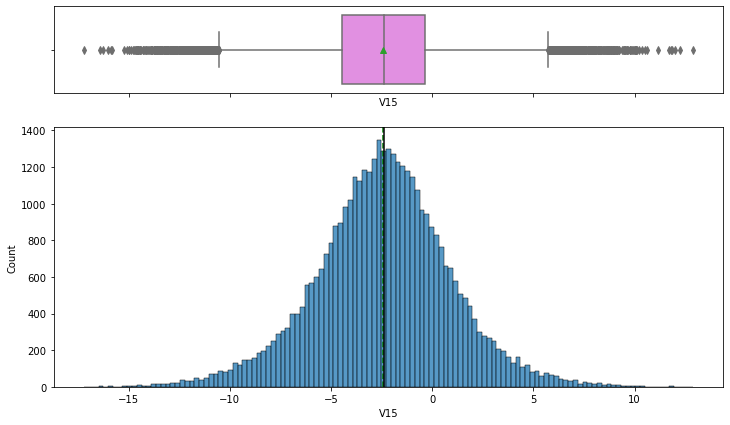

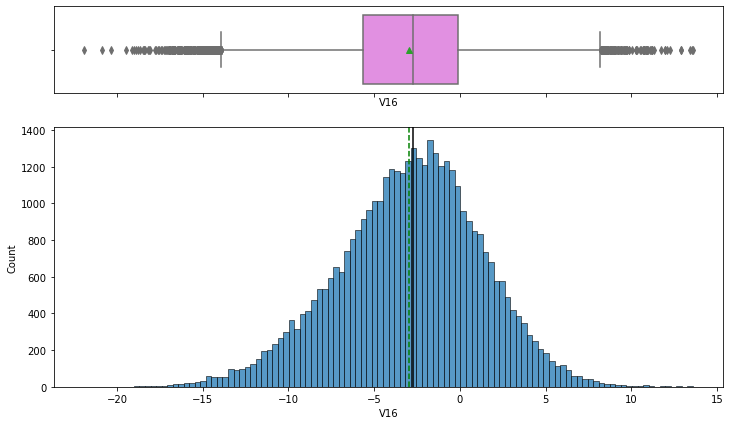

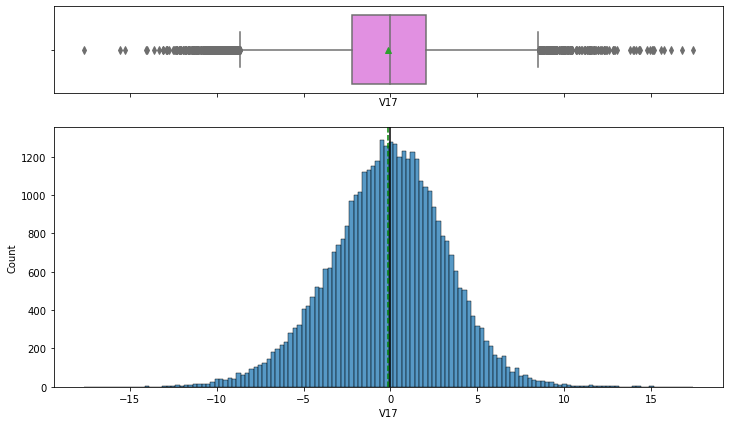

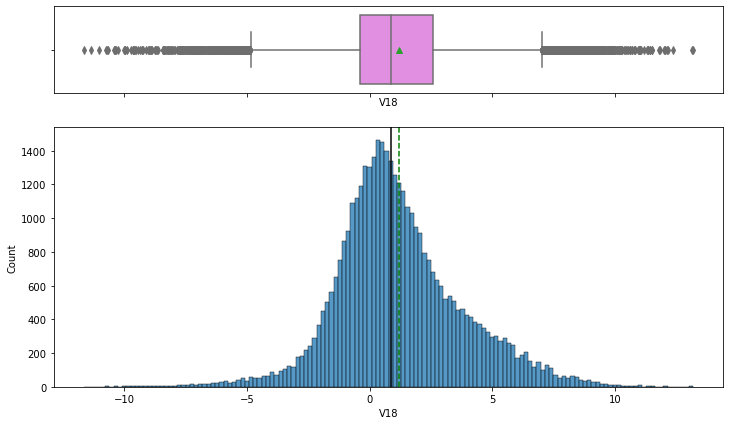

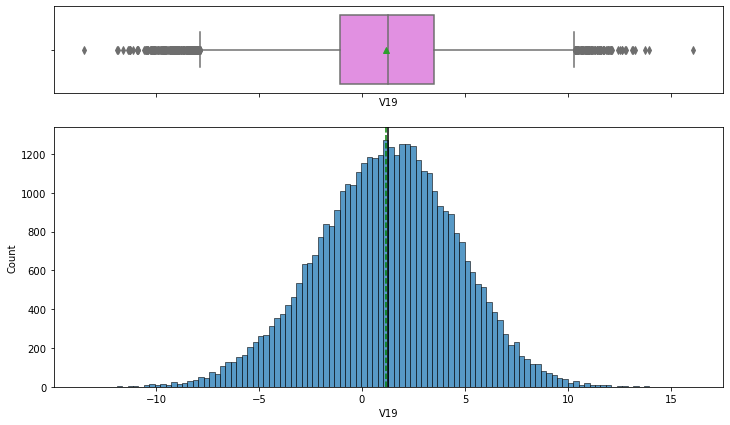

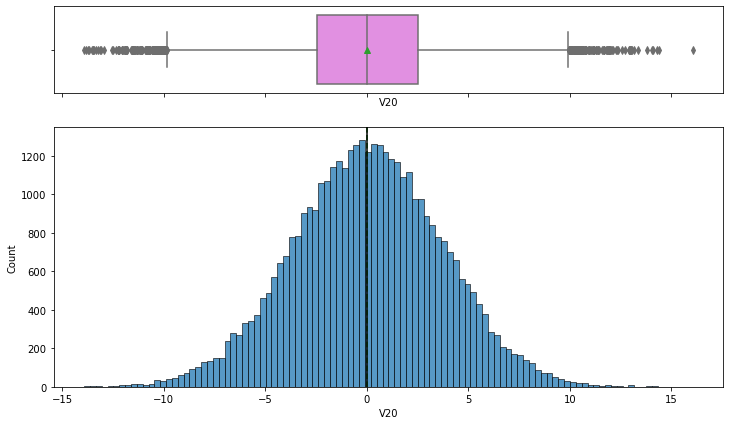

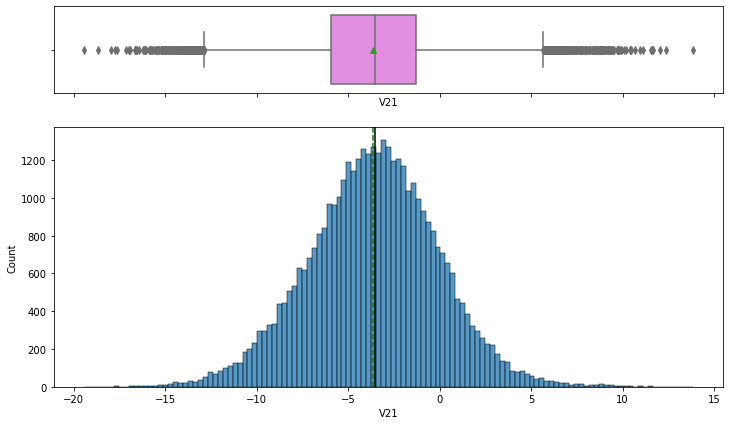

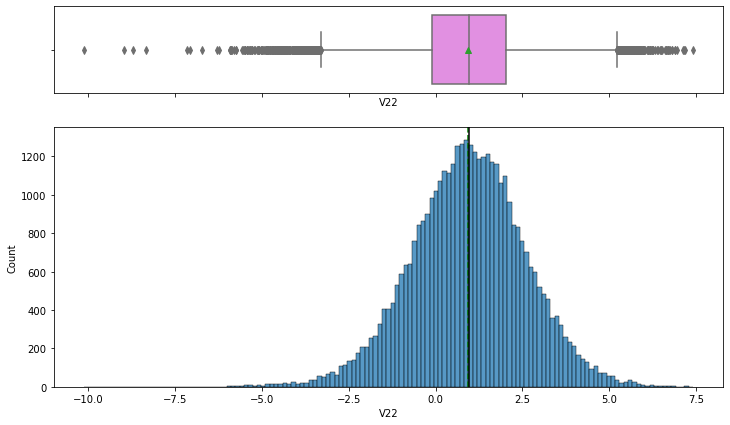

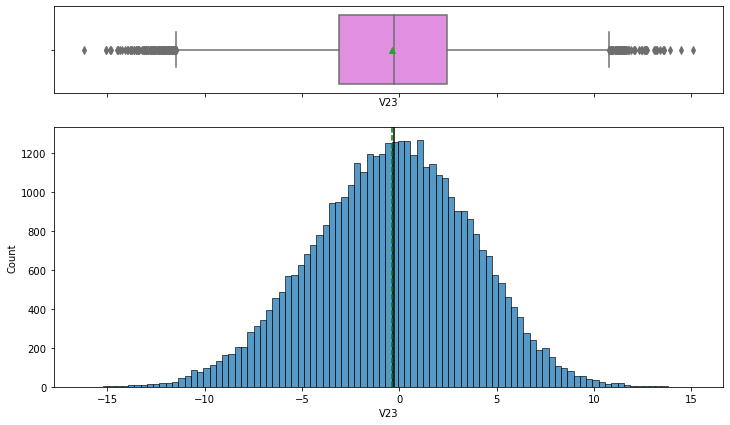

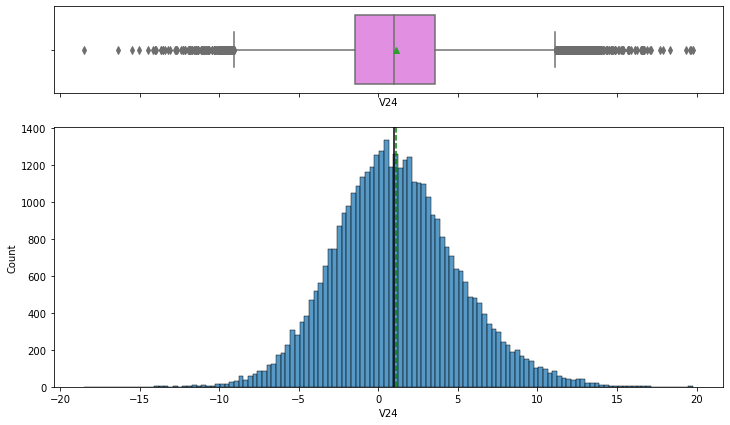

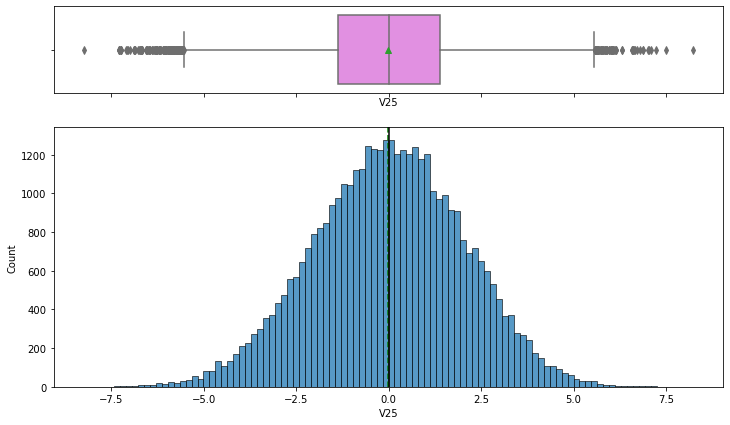

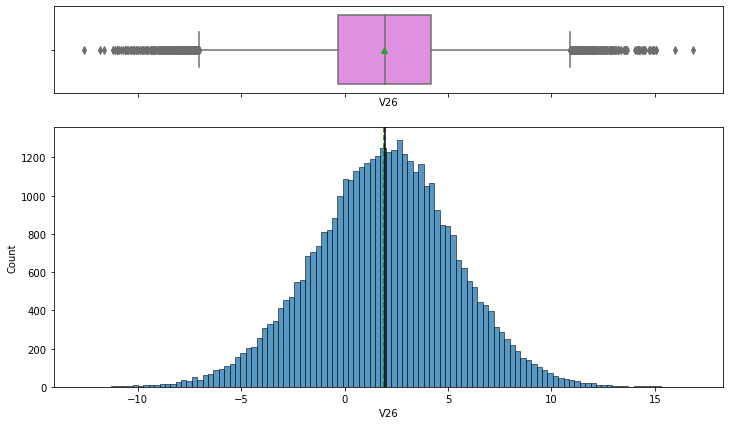

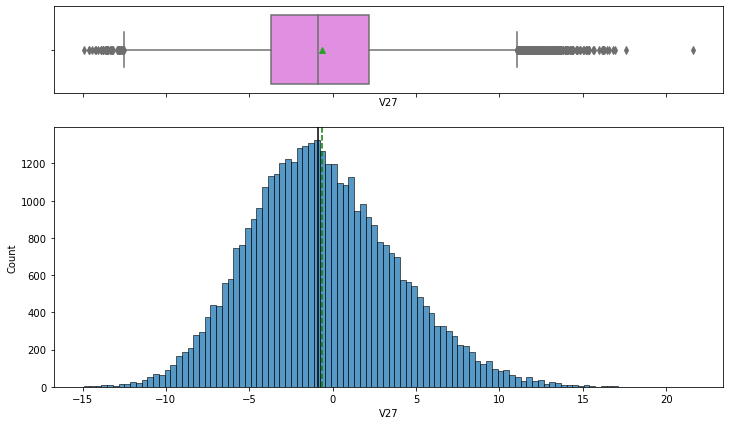

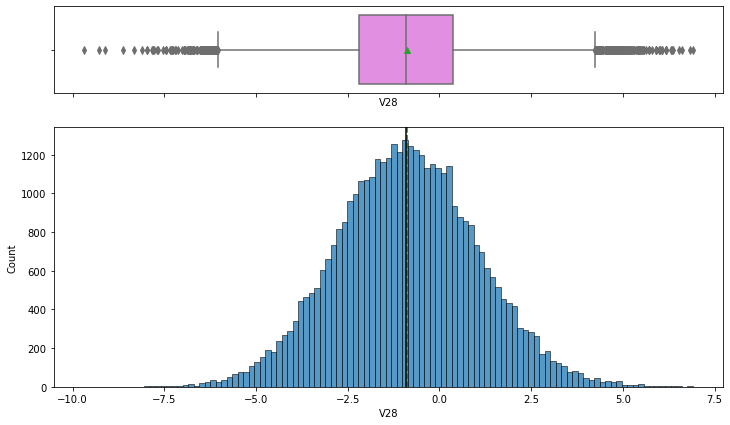

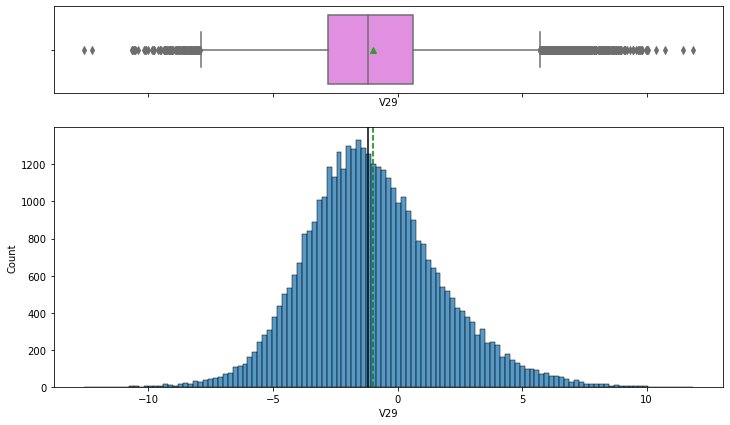

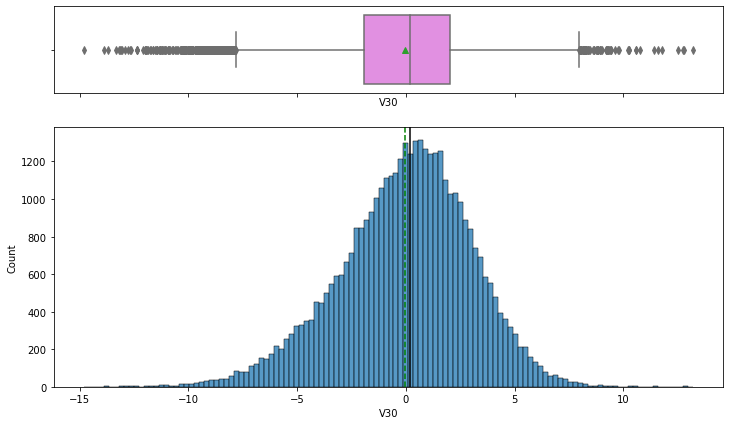

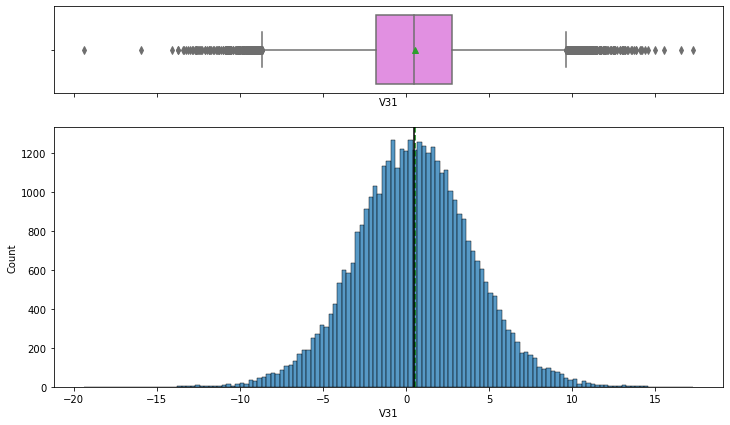

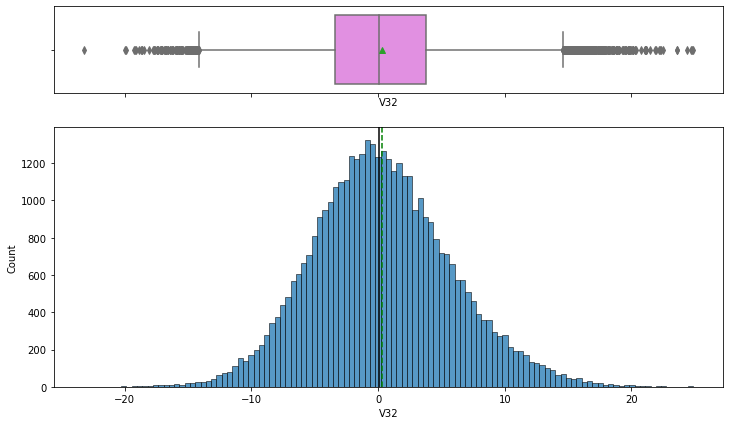

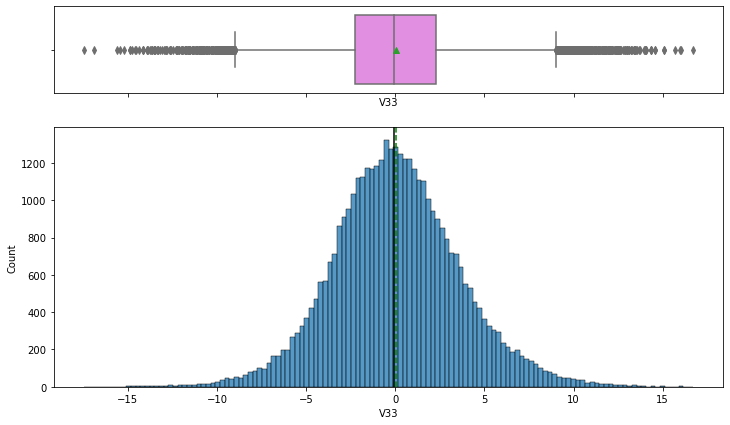

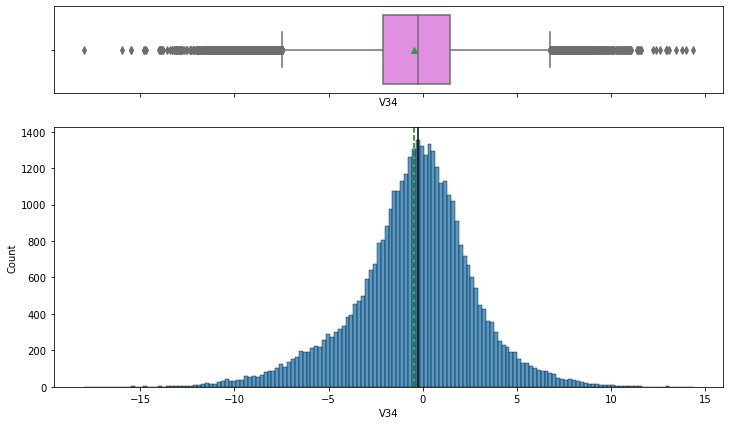

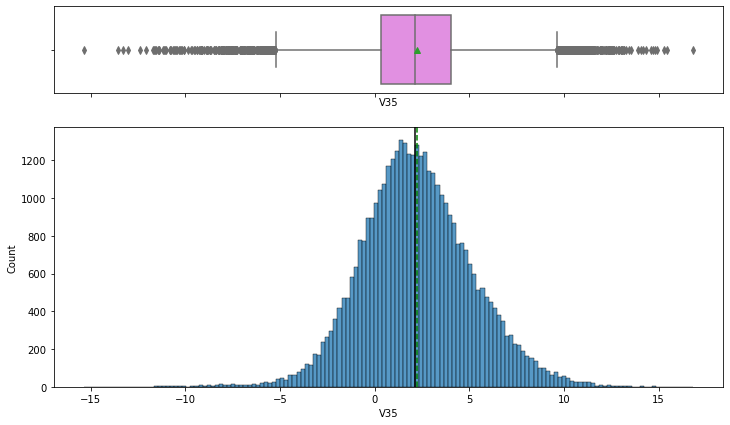

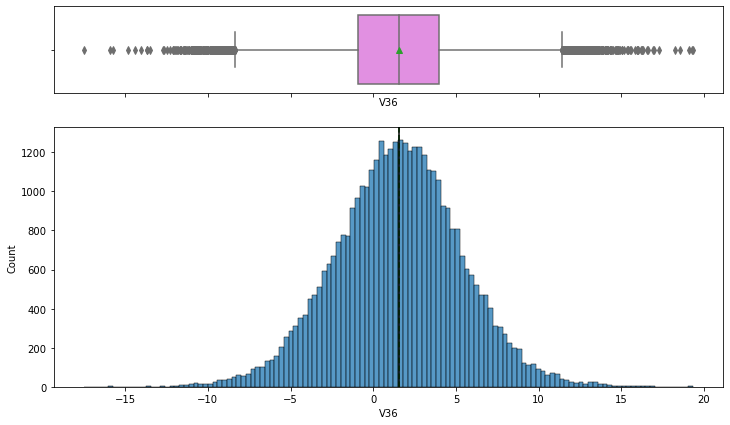

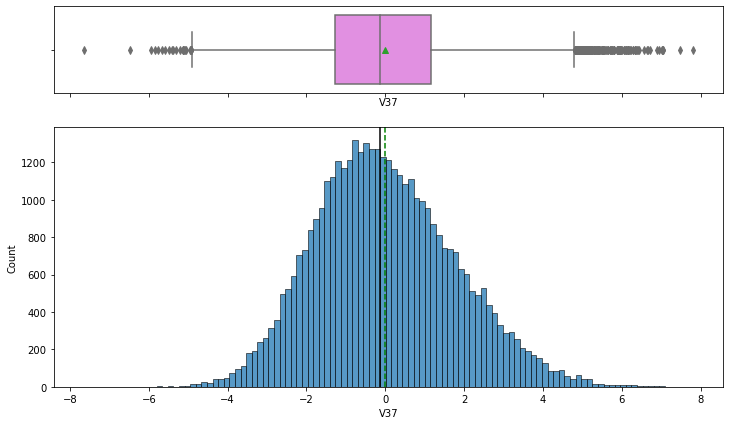

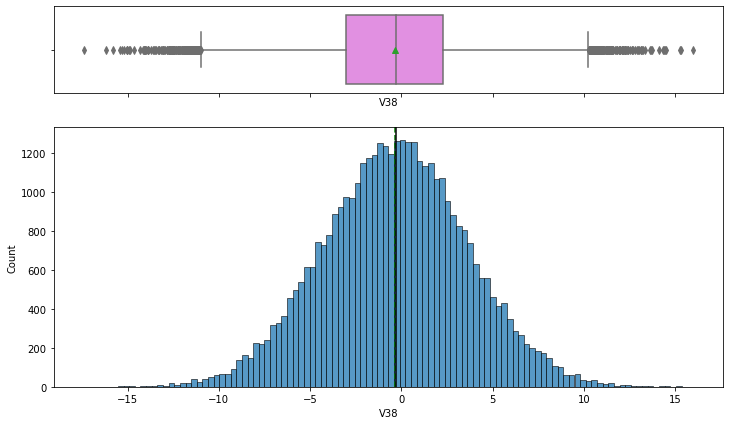

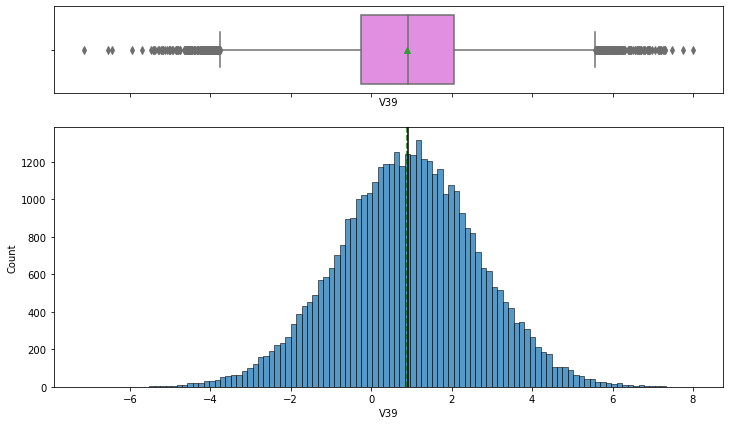

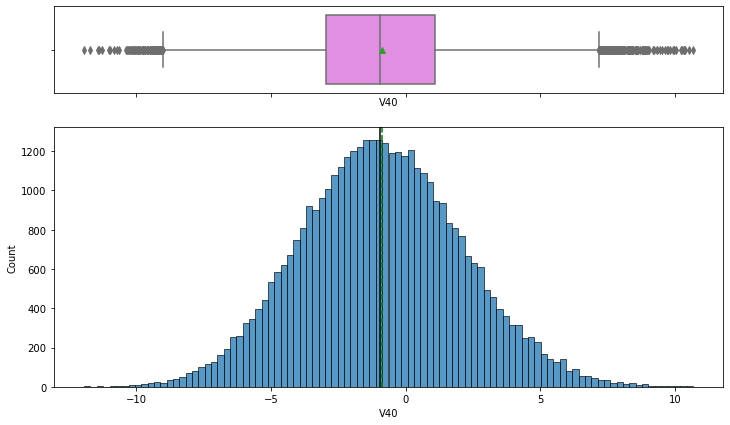

In [16]:
for feature in df_train.columns[df_train.dtypes=='float64']:
    histogram_boxplot(df_train, feature, figsize=(12, 7), kde=False, bins=None)

#### Observations
- The distributions for 'V1', 'V18', and 'V27' appear right-skewed
- The distributions for 'V22' and 'V30' appear right-skewed
- All of the sensor variables appear normally distributed, as expected
    - Therefore, for the missing values in 'V1' and 'V2', simply filling these missing values with a median value should be sufficient 

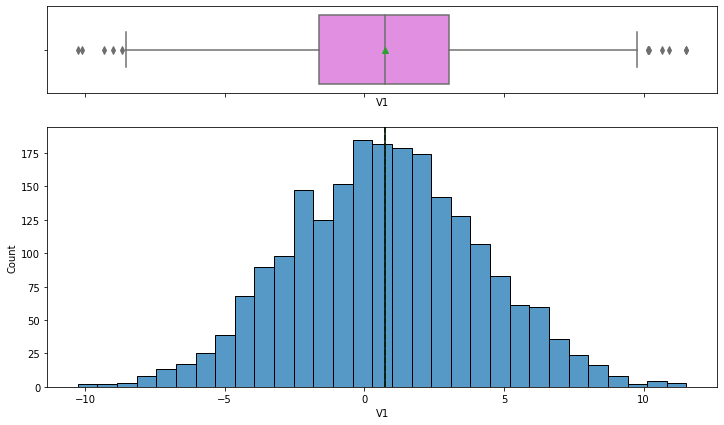

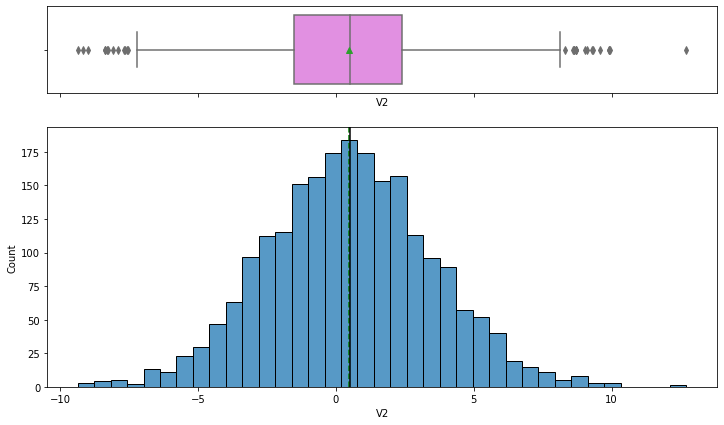

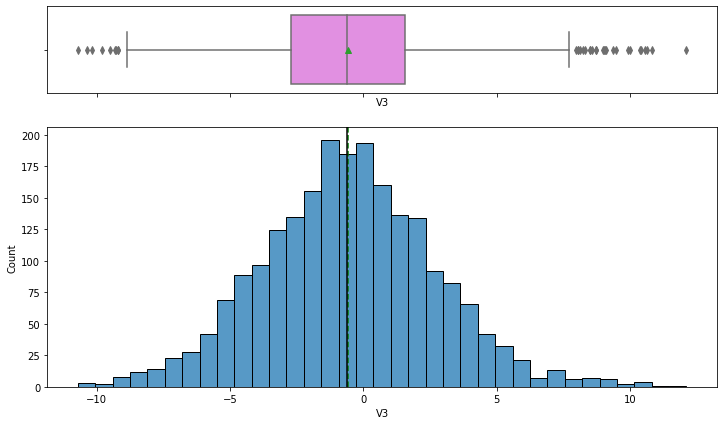

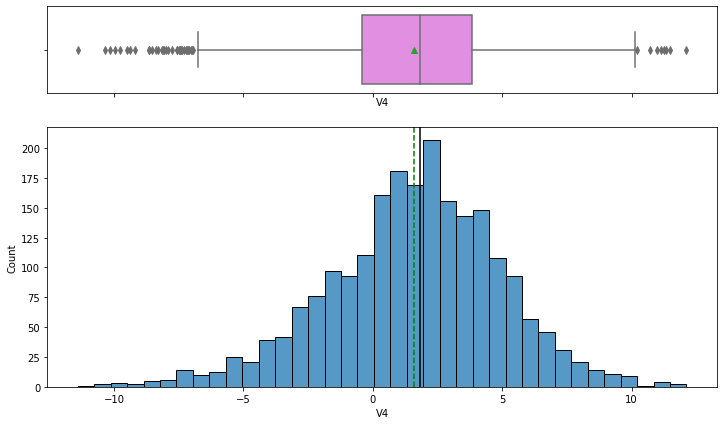

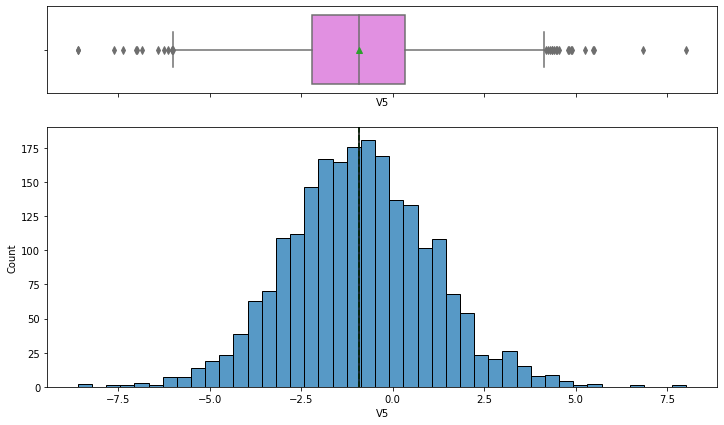

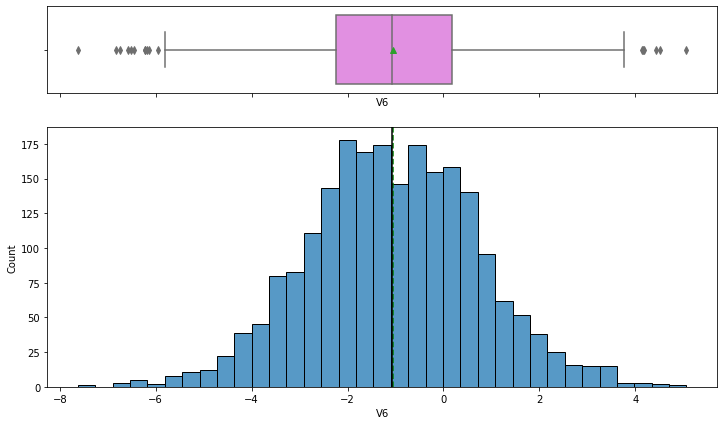

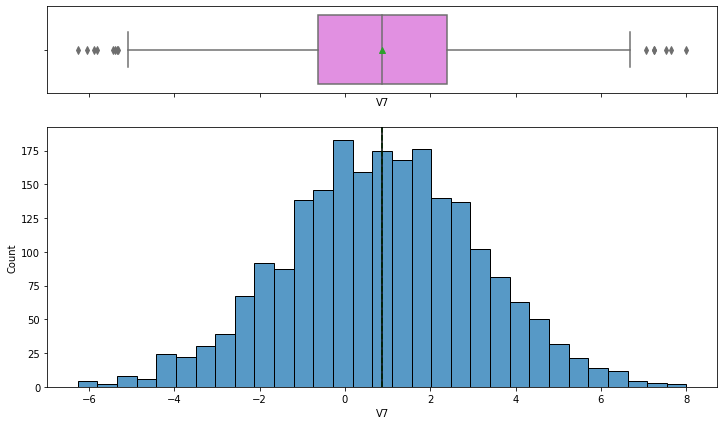

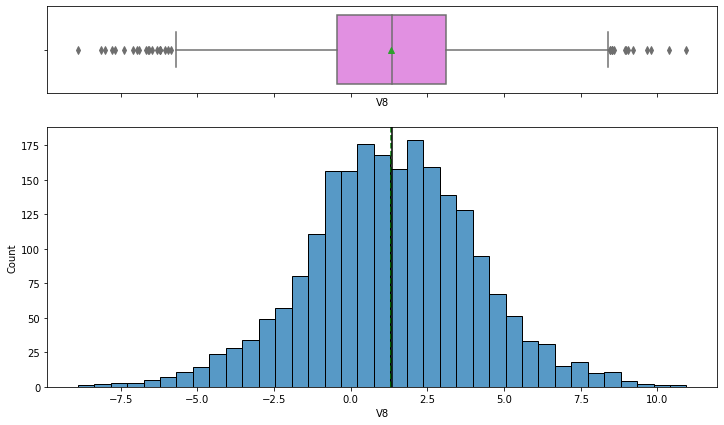

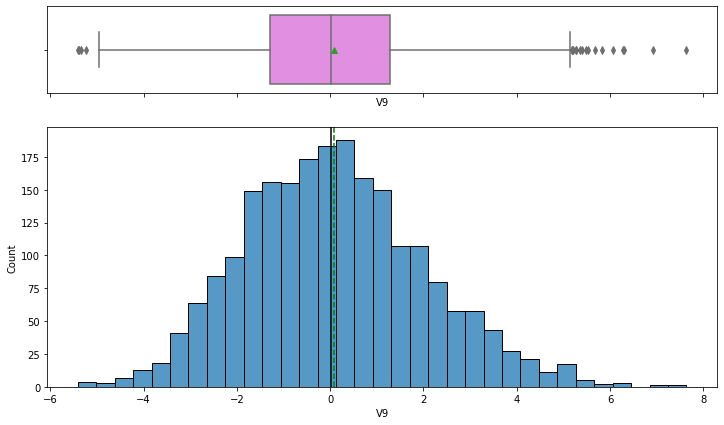

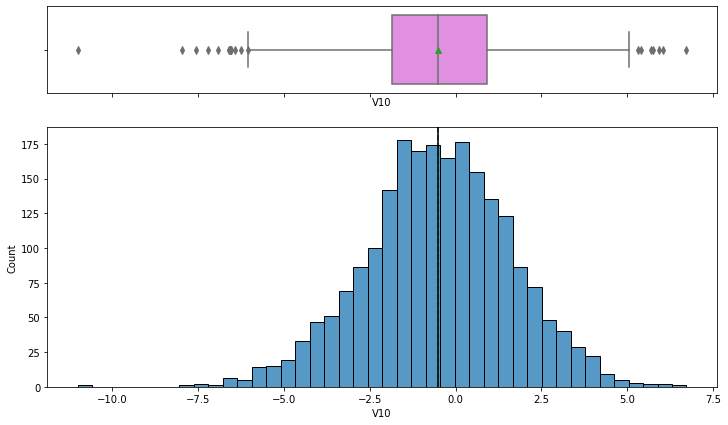

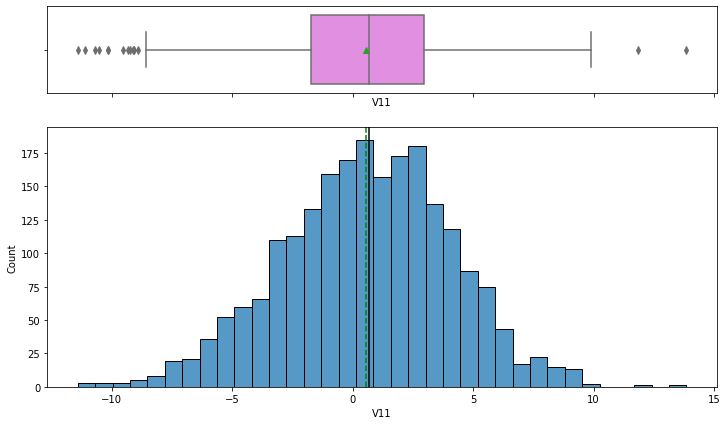

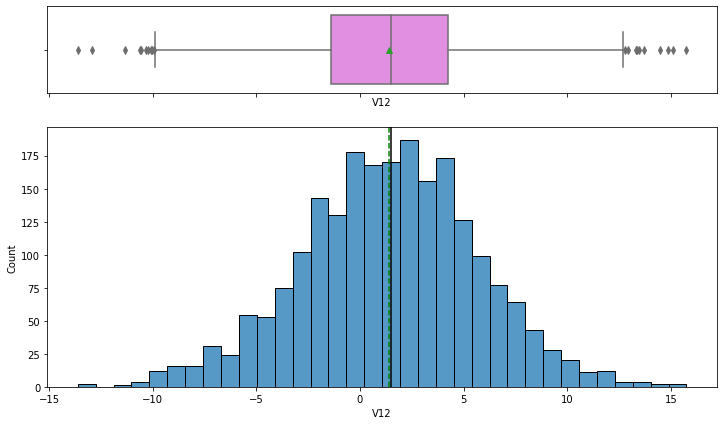

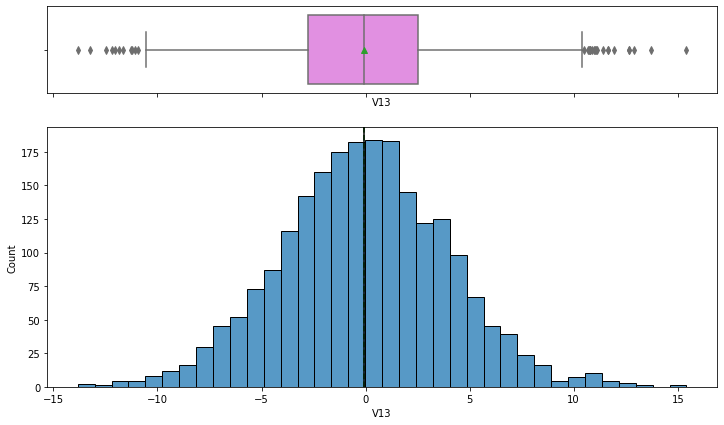

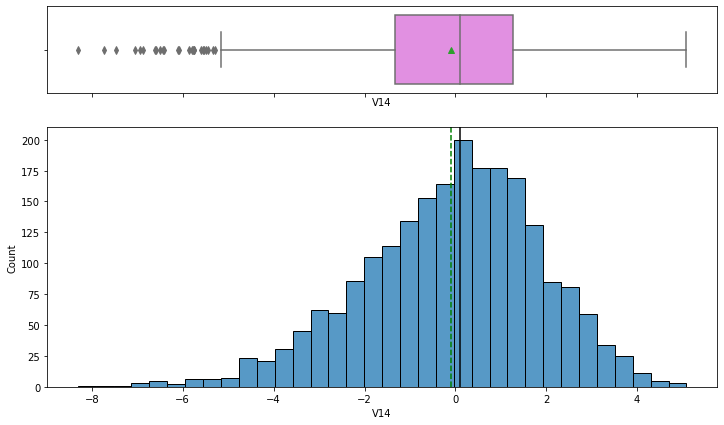

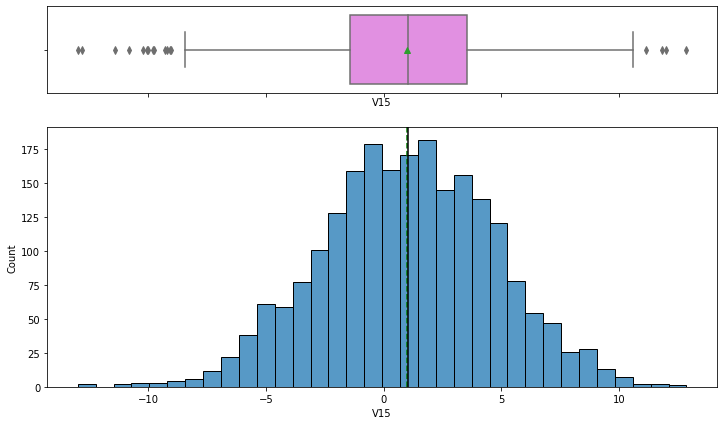

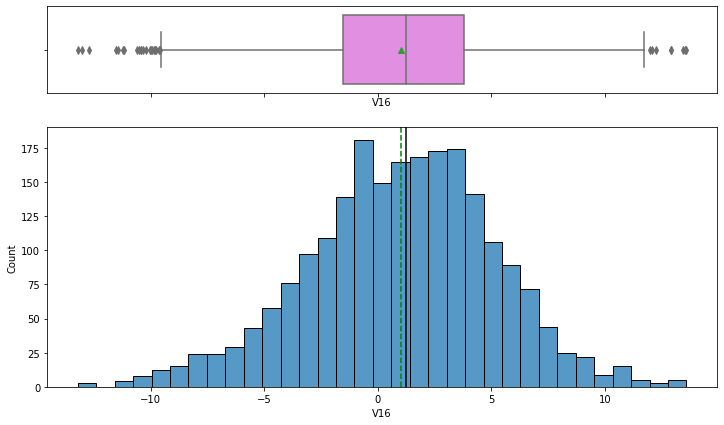

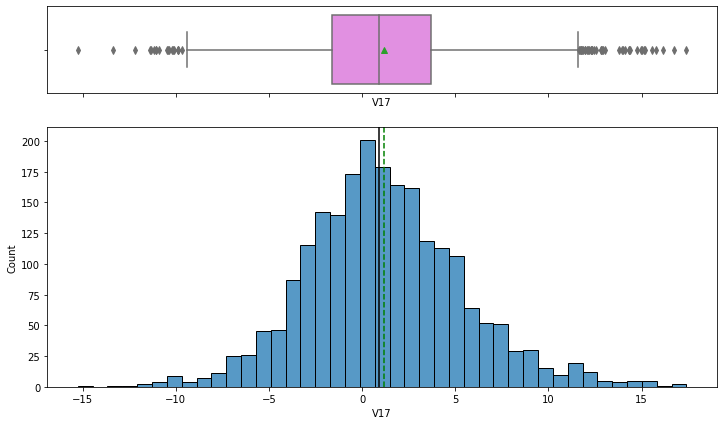

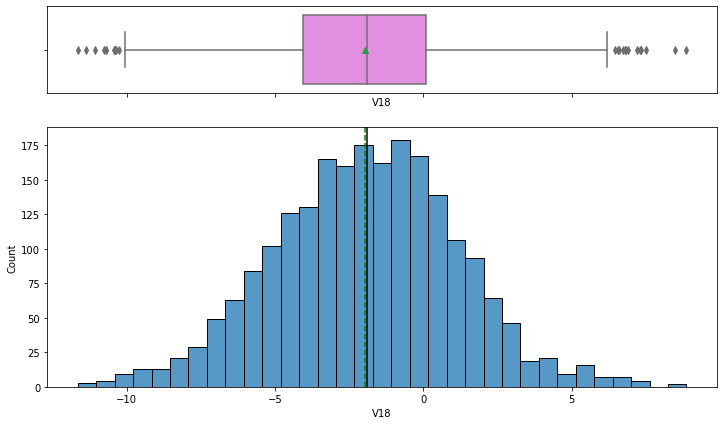

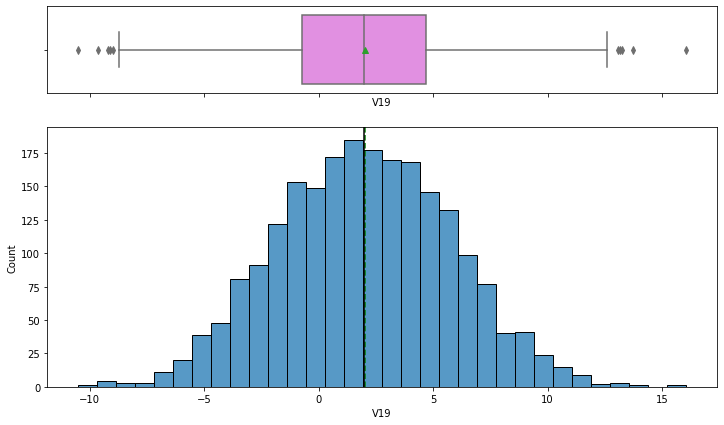

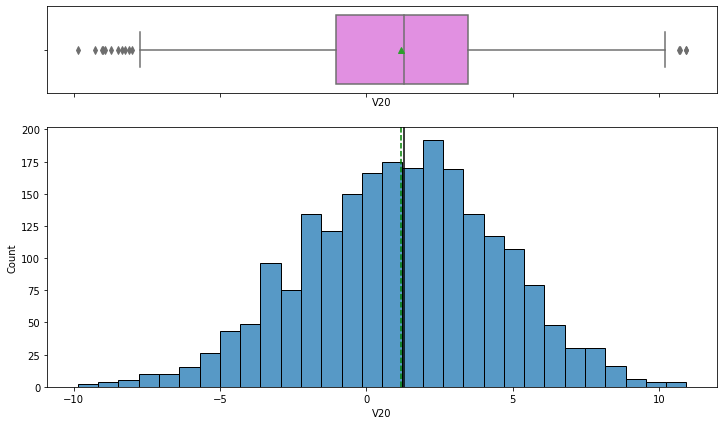

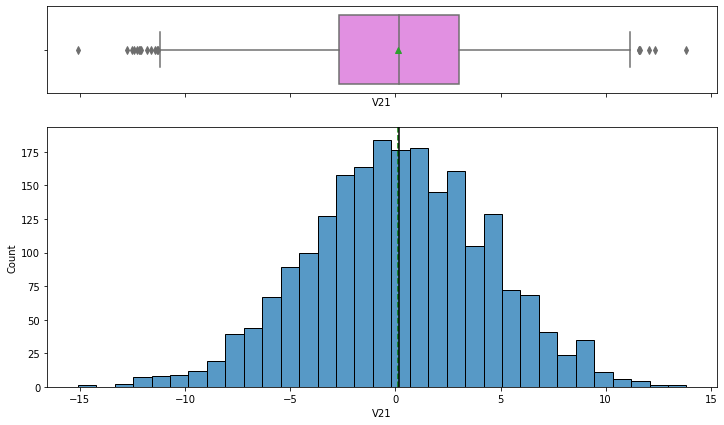

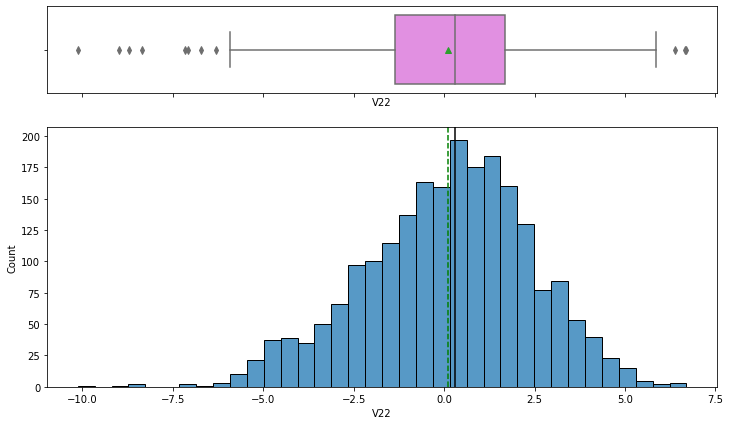

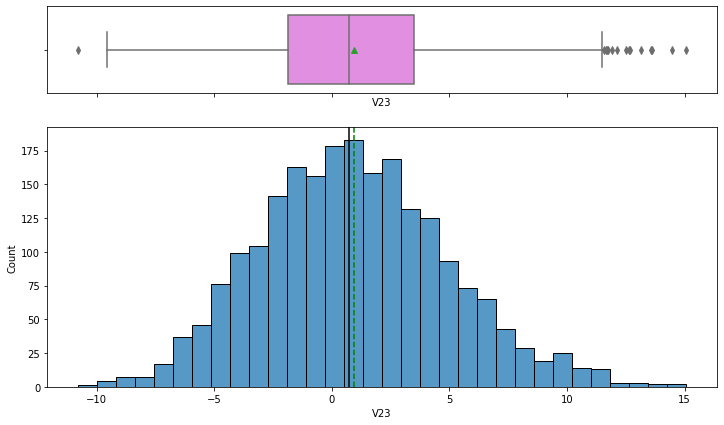

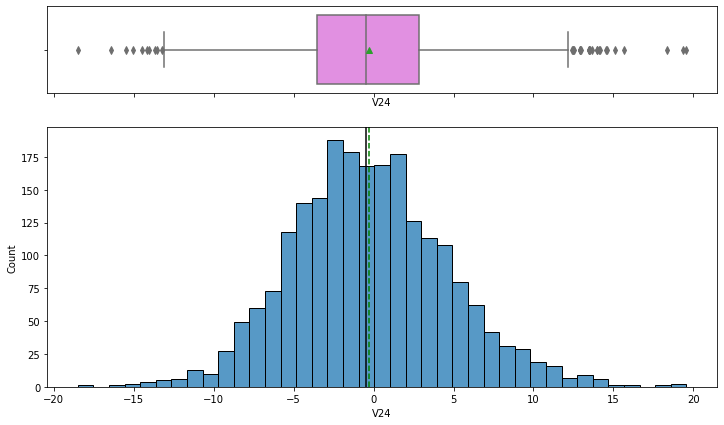

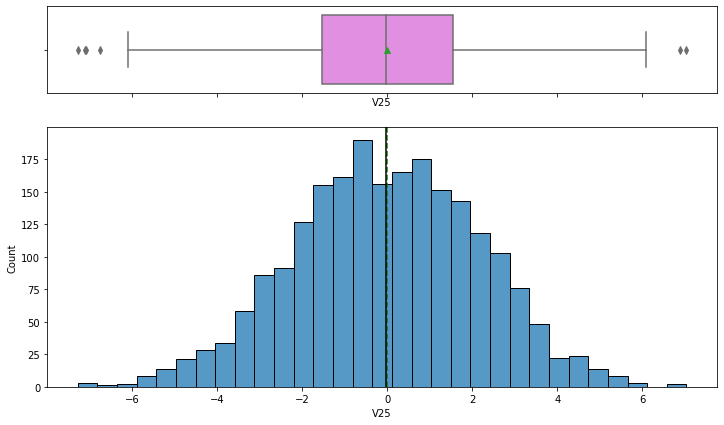

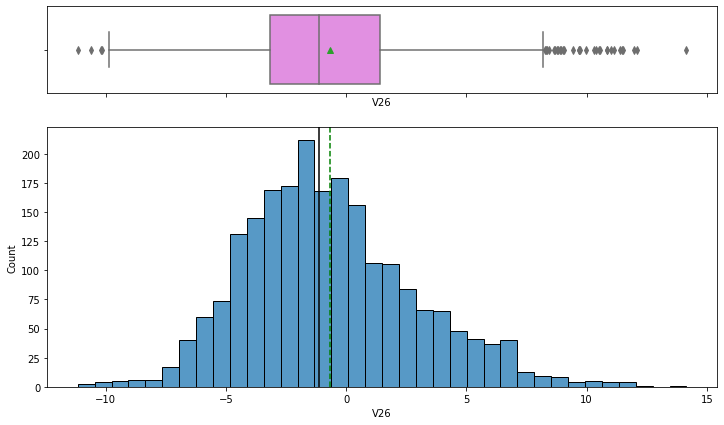

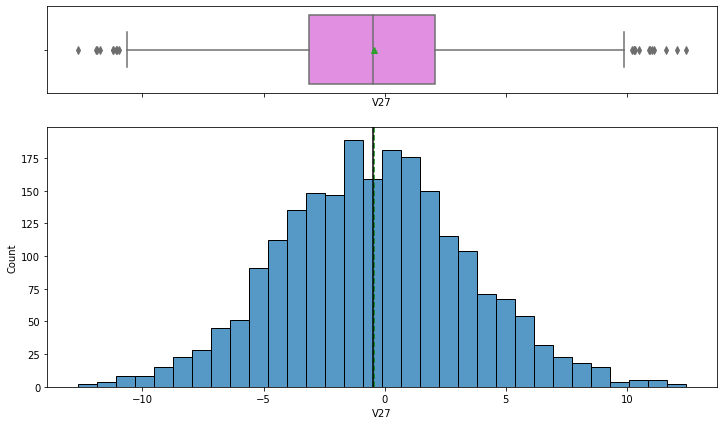

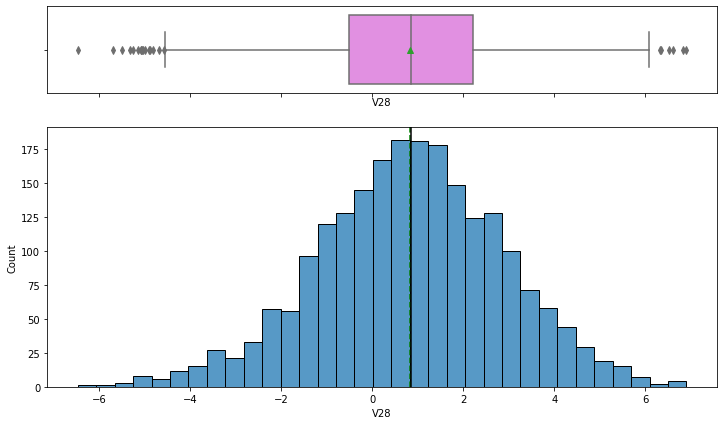

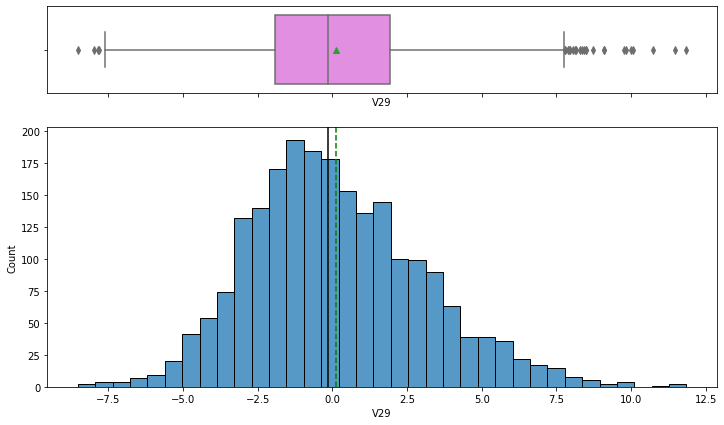

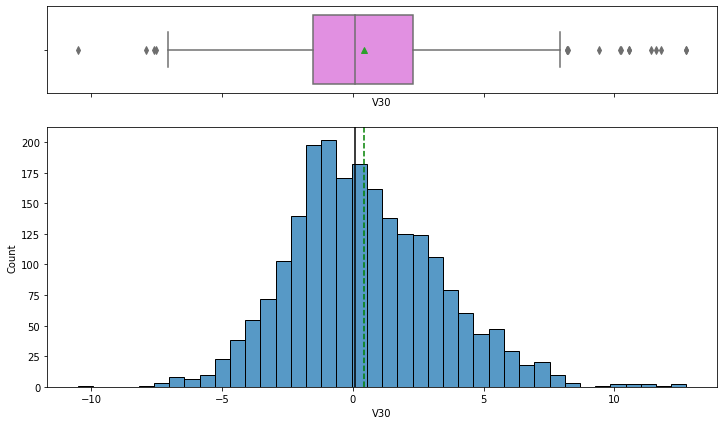

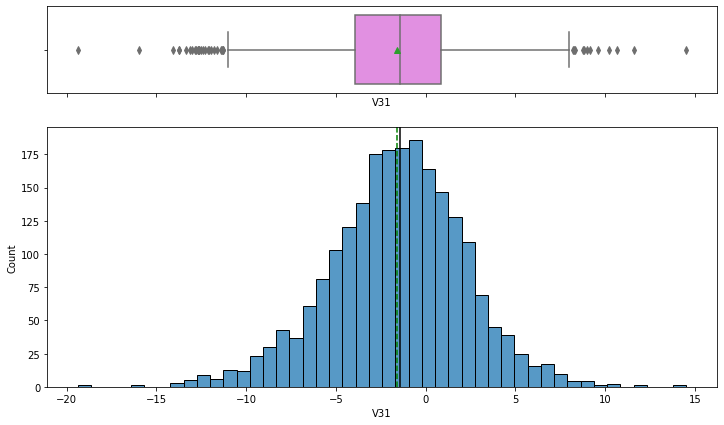

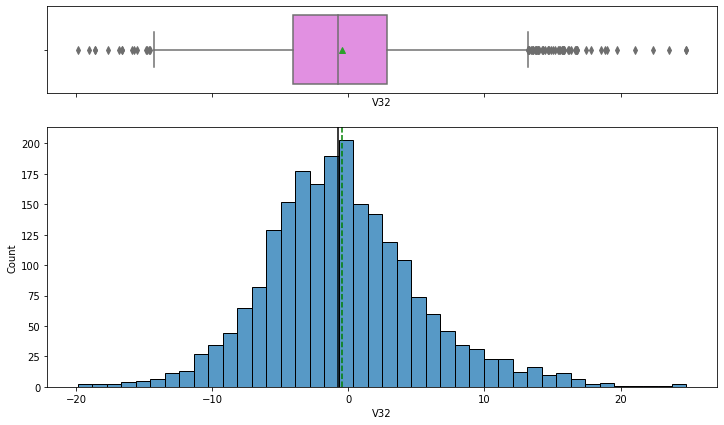

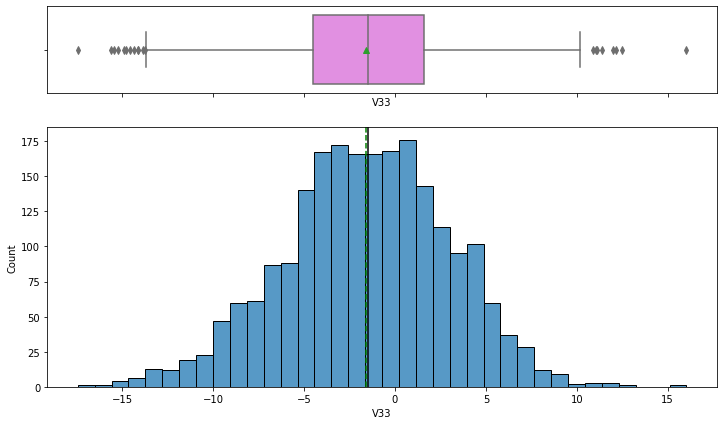

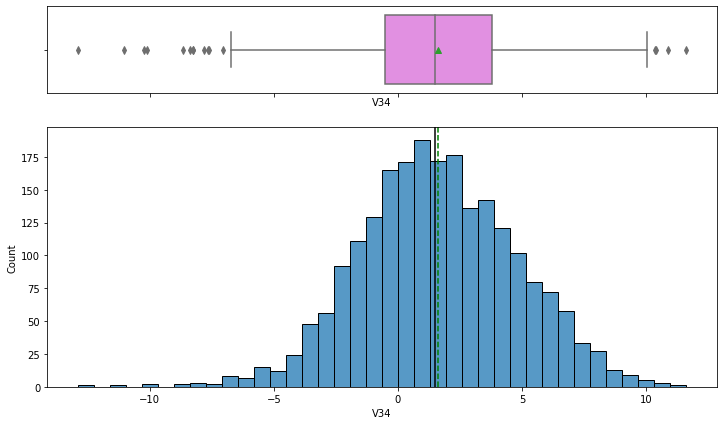

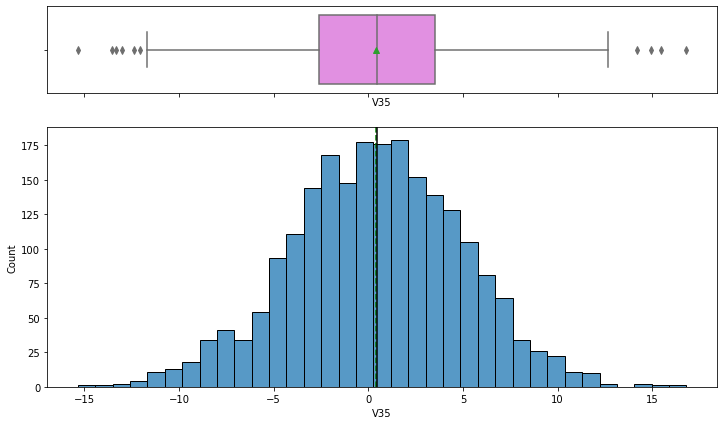

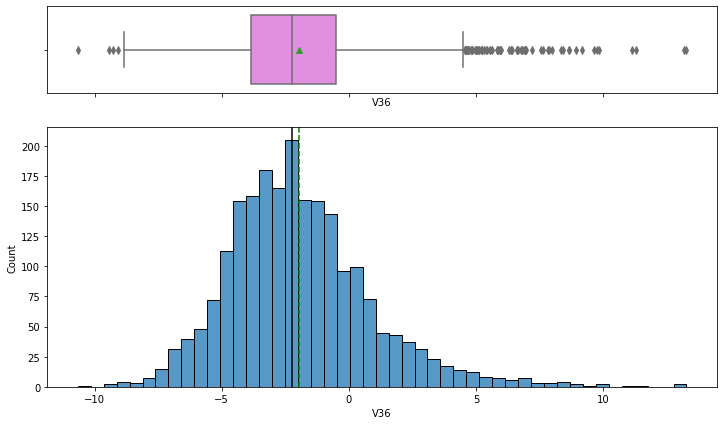

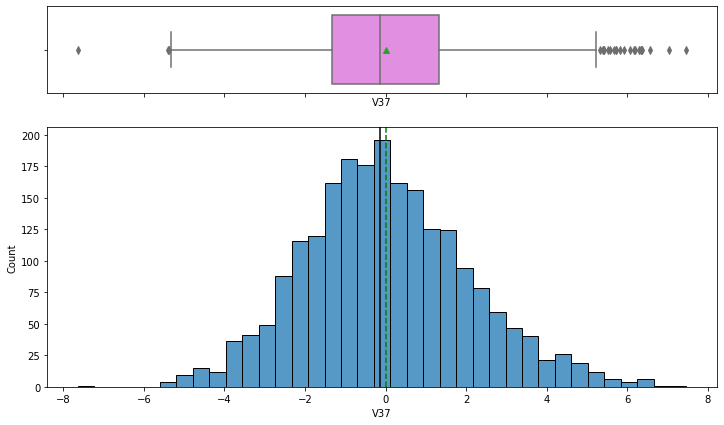

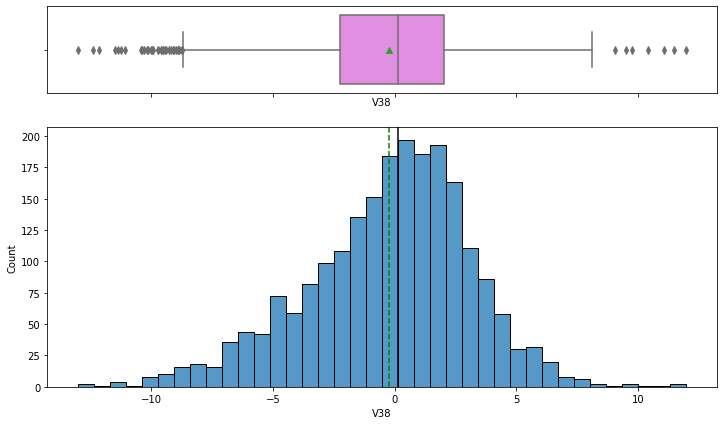

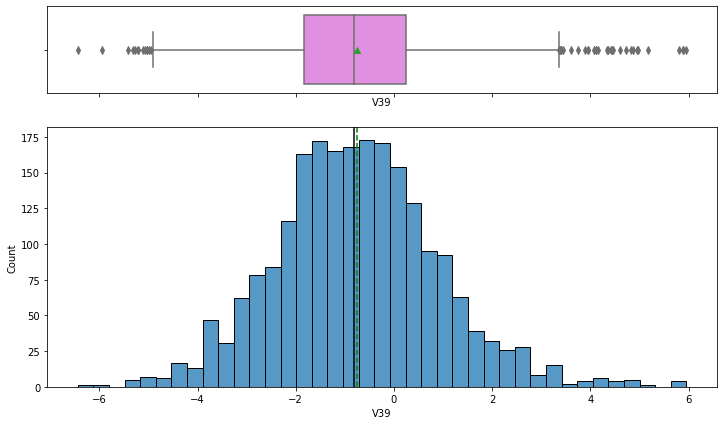

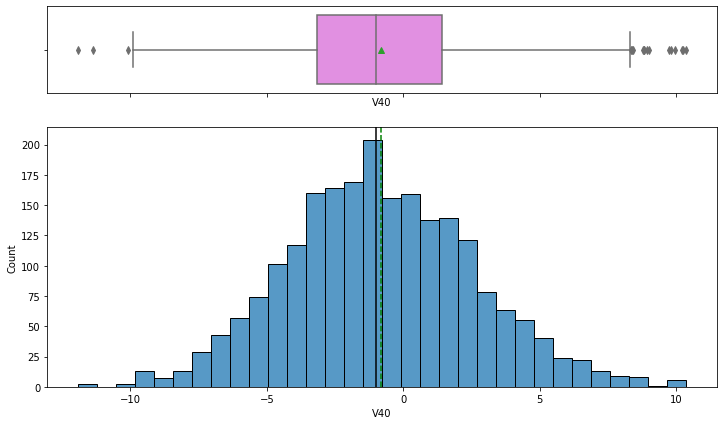

In [17]:
for feature in df_test.columns[df_test.dtypes=='float64']:
    histogram_boxplot(fail, feature, figsize=(12, 7), kde=False, bins=None)

#### Observations
- All of the sensor variables appear normally distributed for both the training and test data, as expected
    - Therefore, for the missing values in 'V1' and 'V2' in both dataframes, simply filling these missing values with a median value should be sufficient 

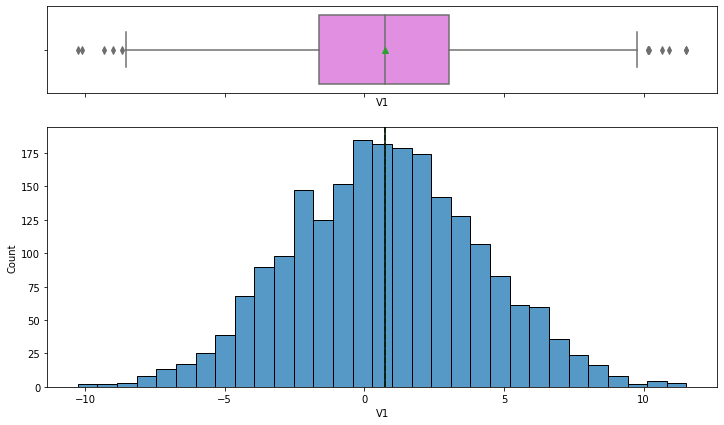

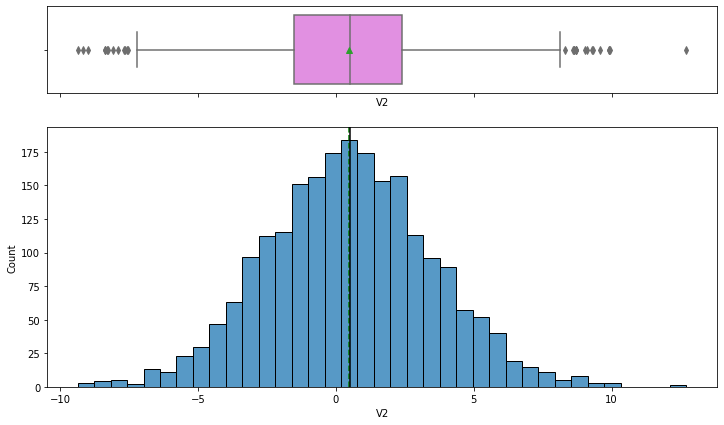

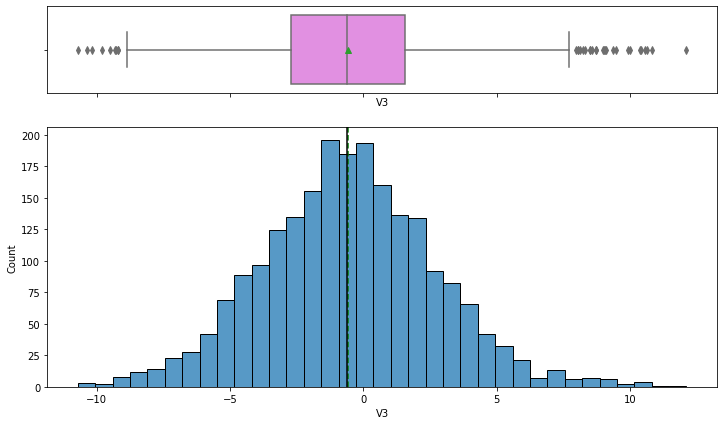

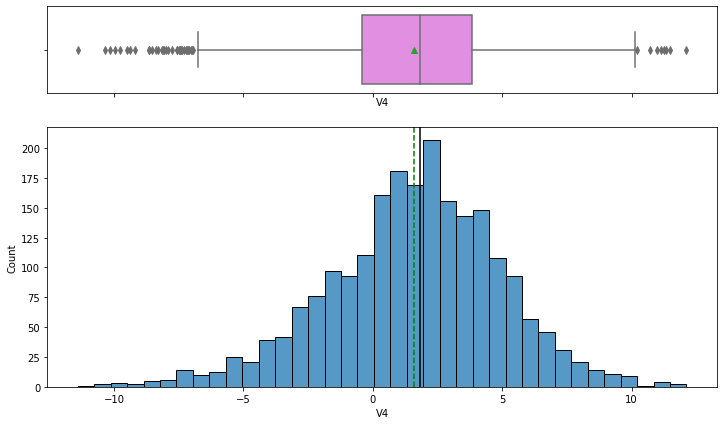

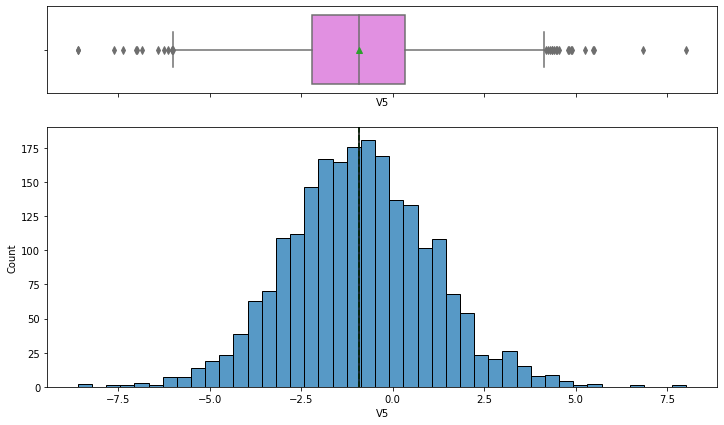

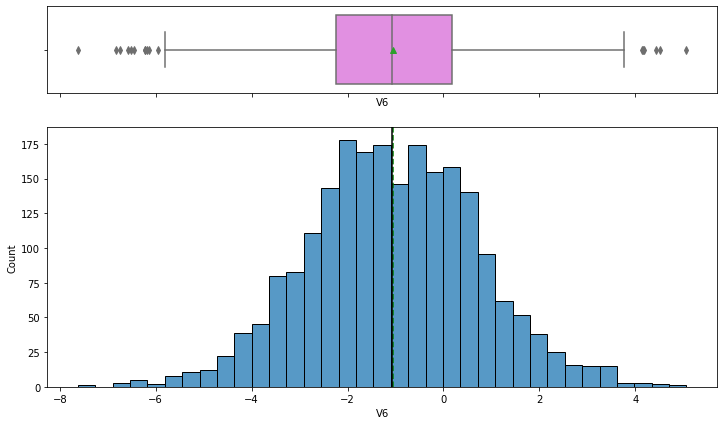

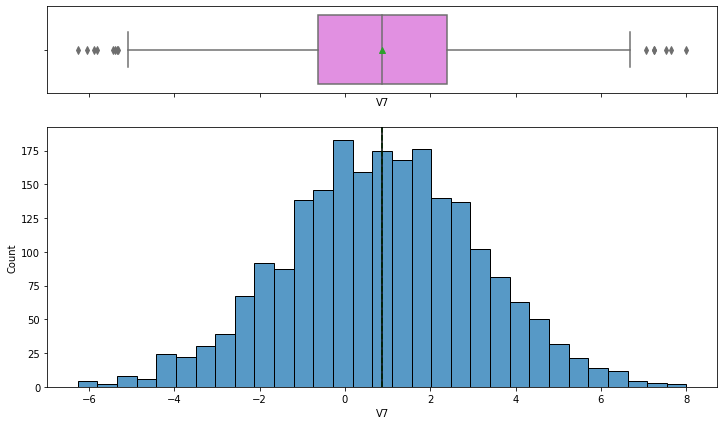

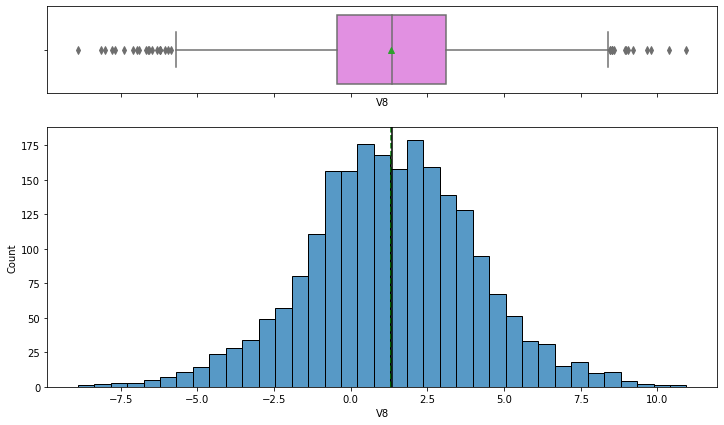

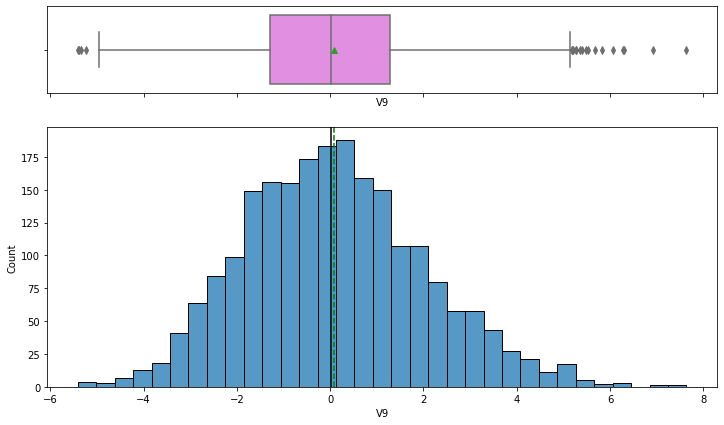

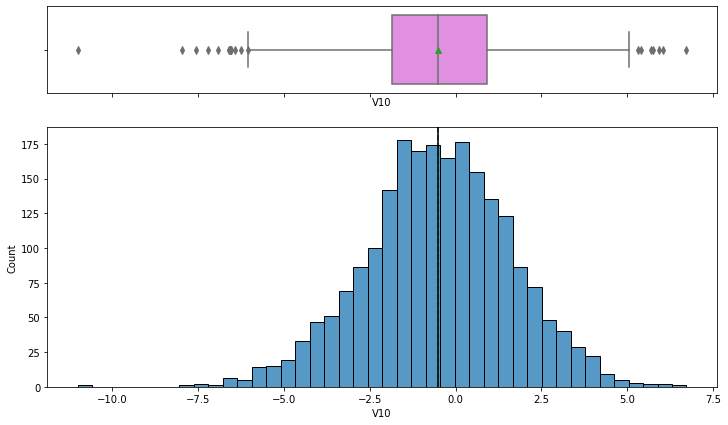

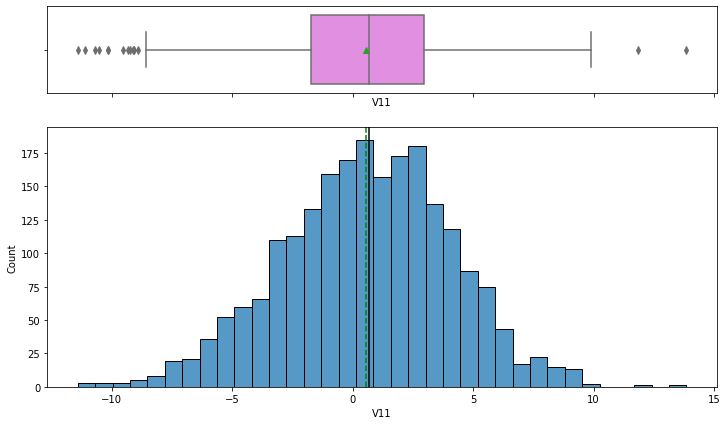

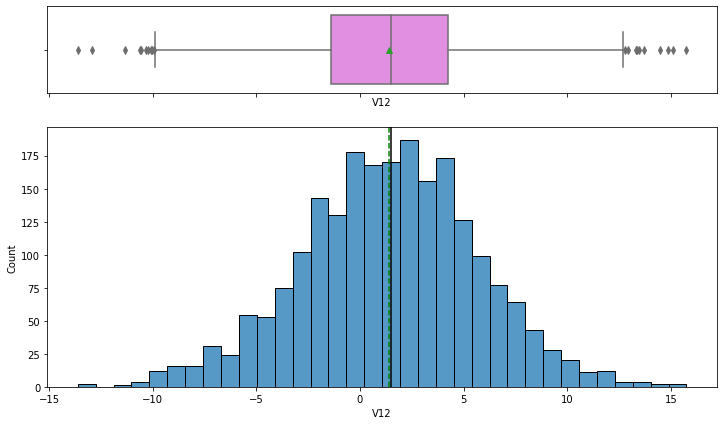

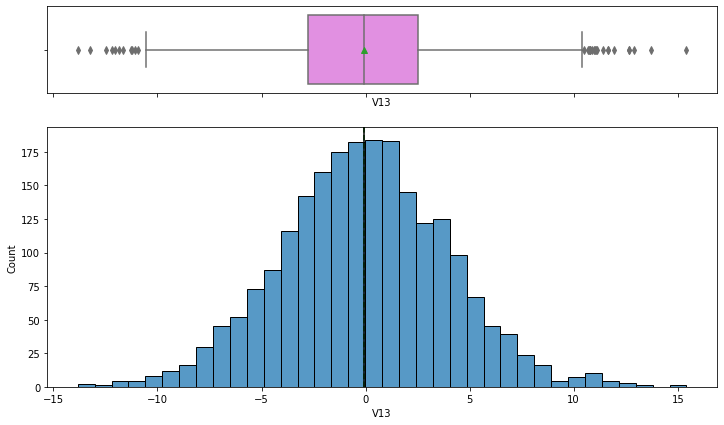

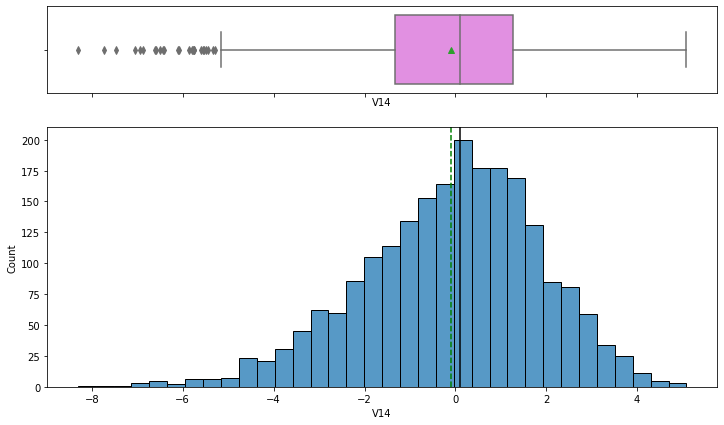

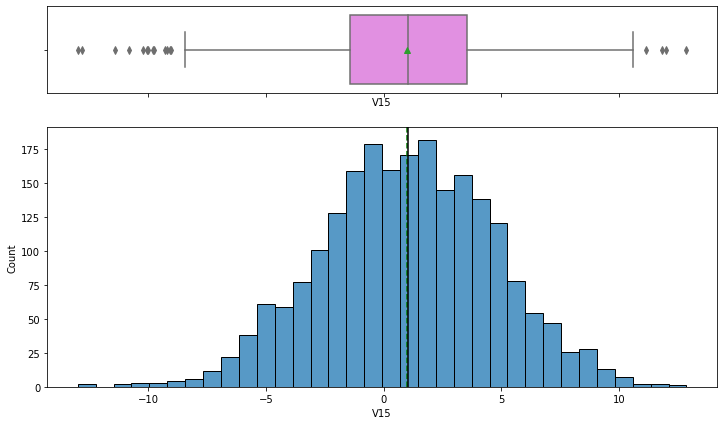

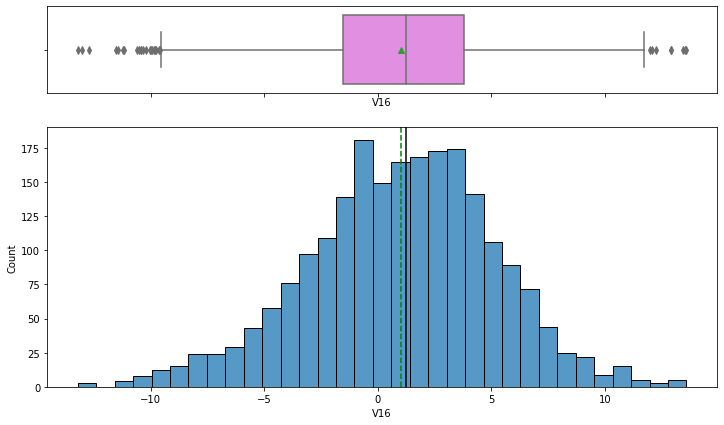

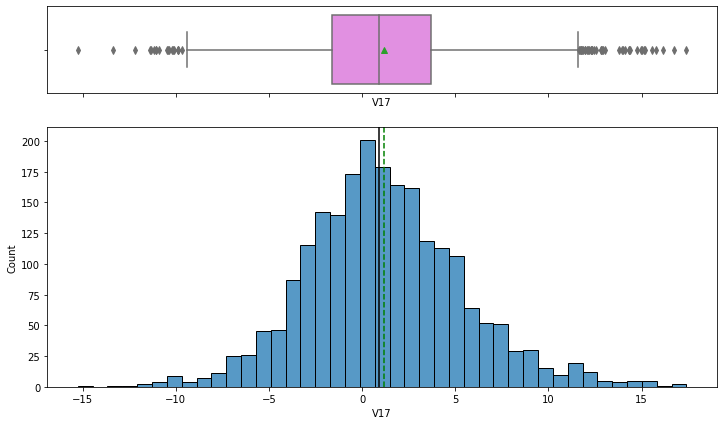

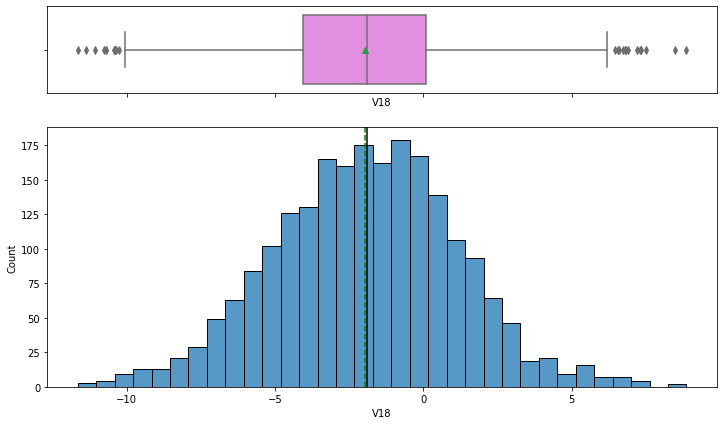

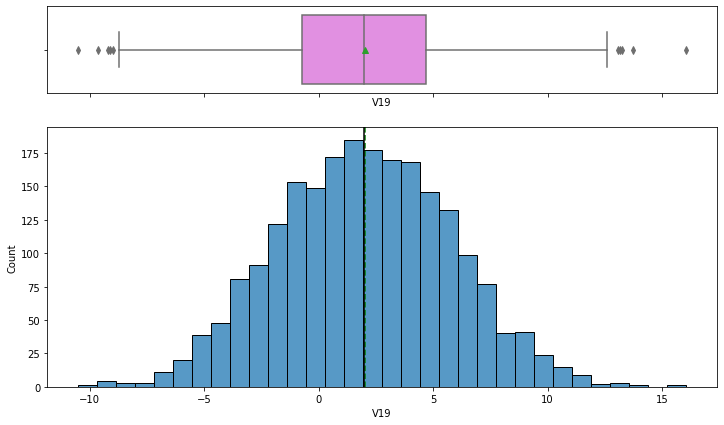

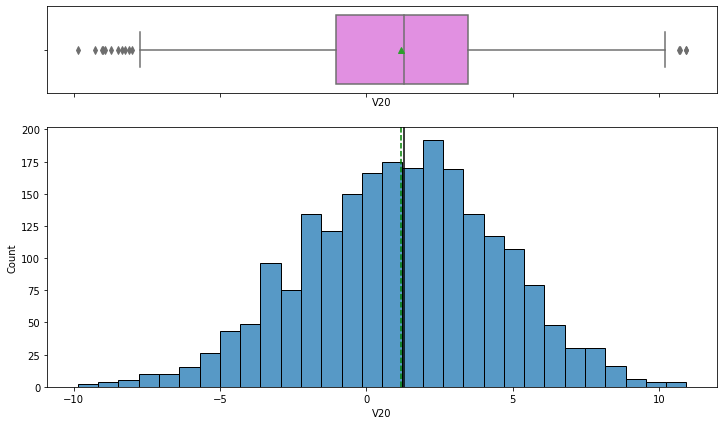

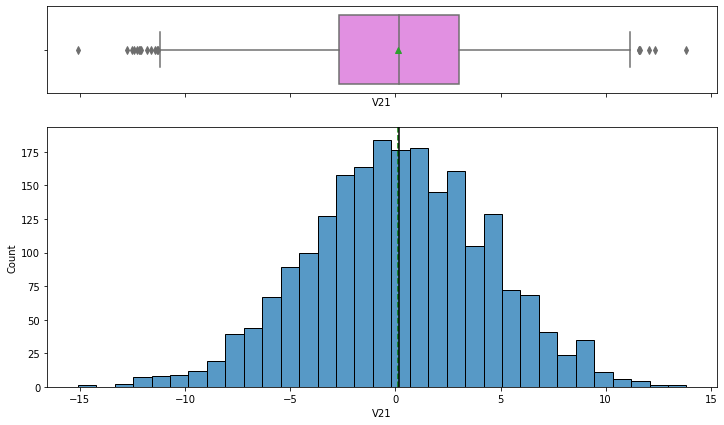

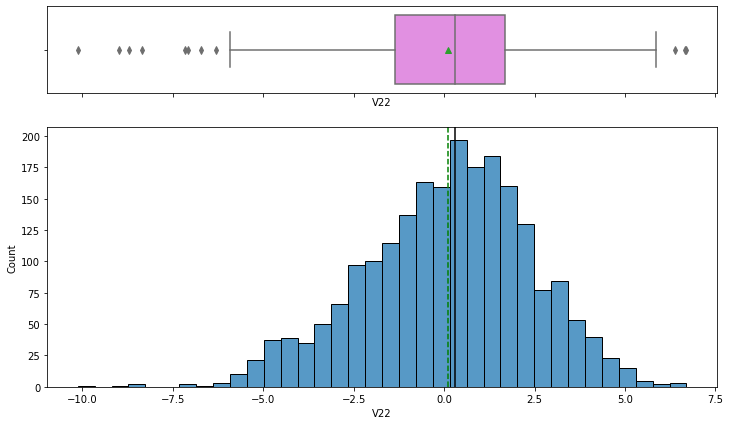

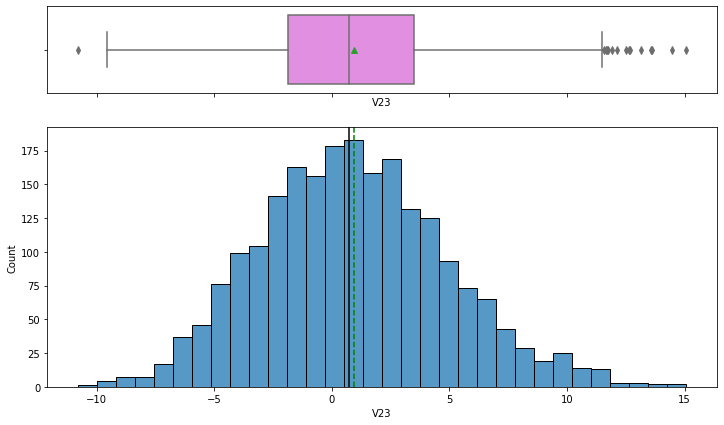

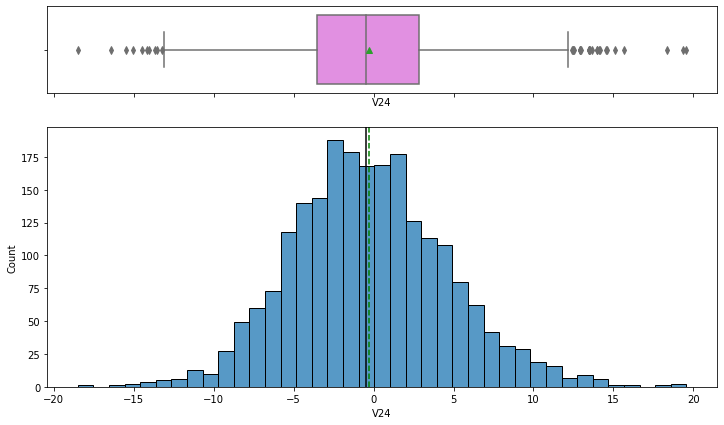

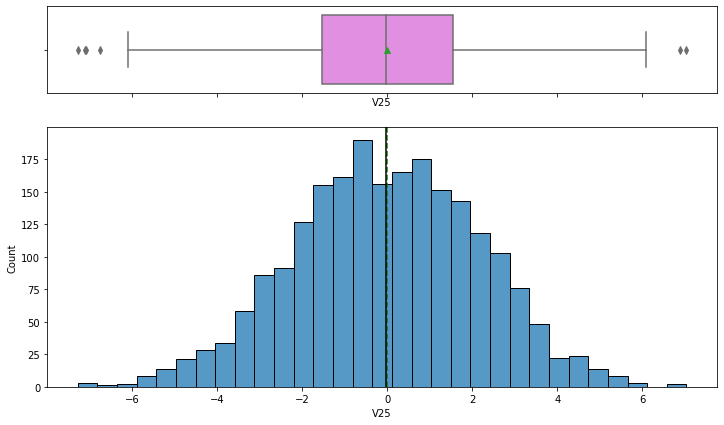

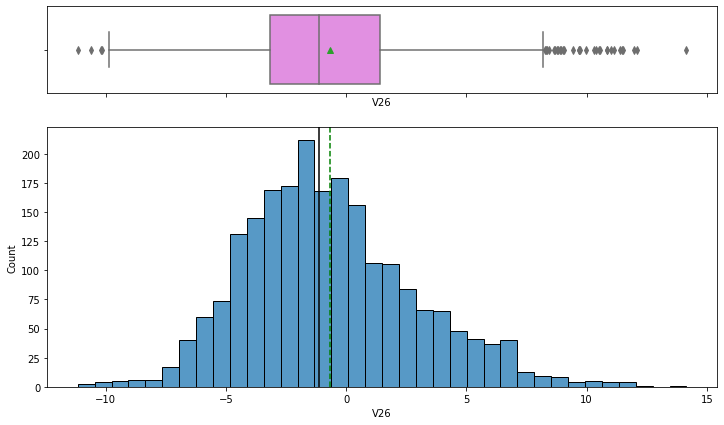

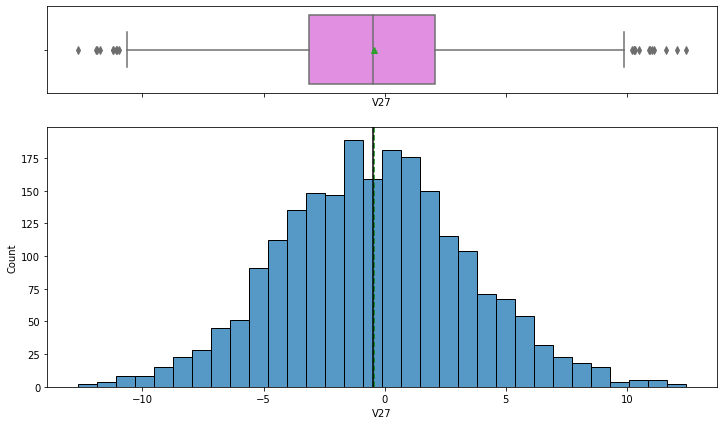

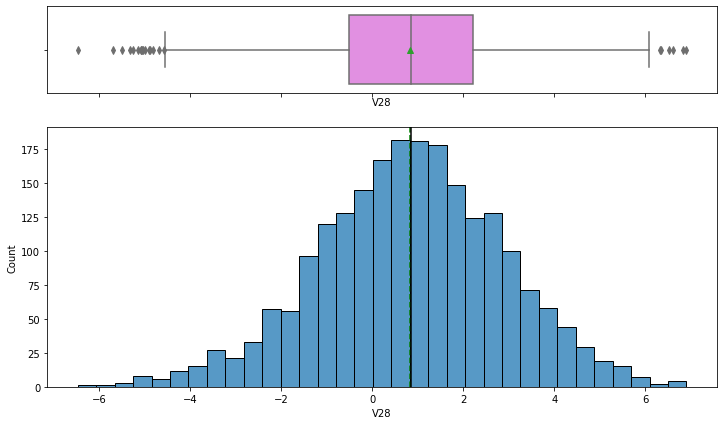

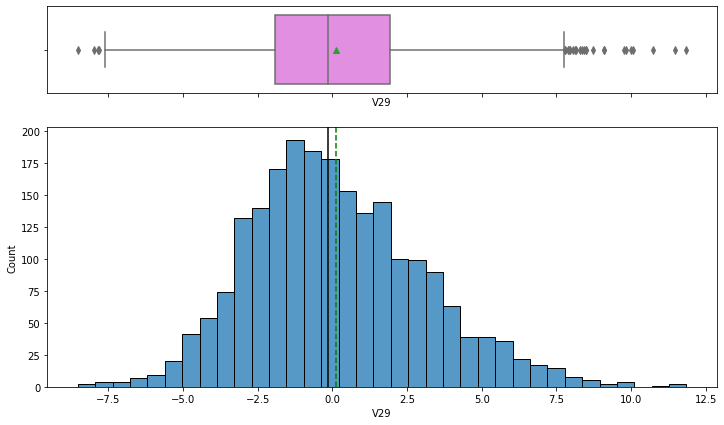

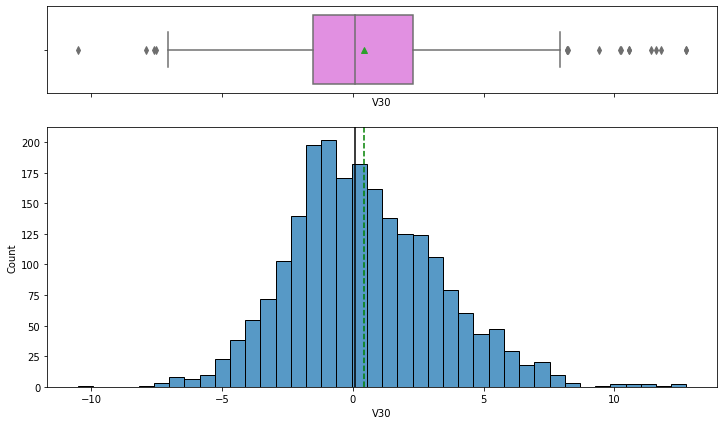

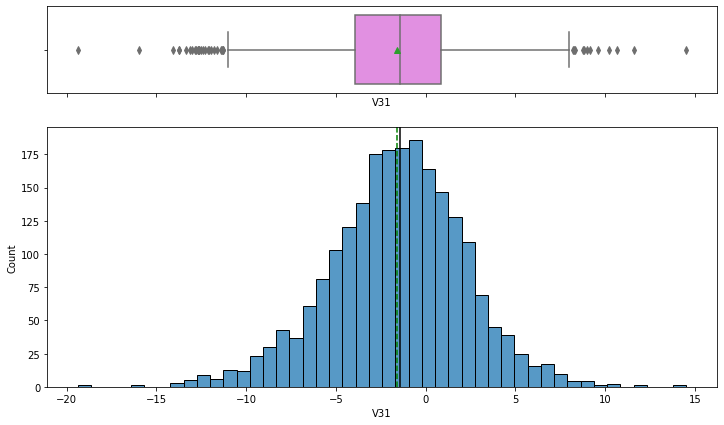

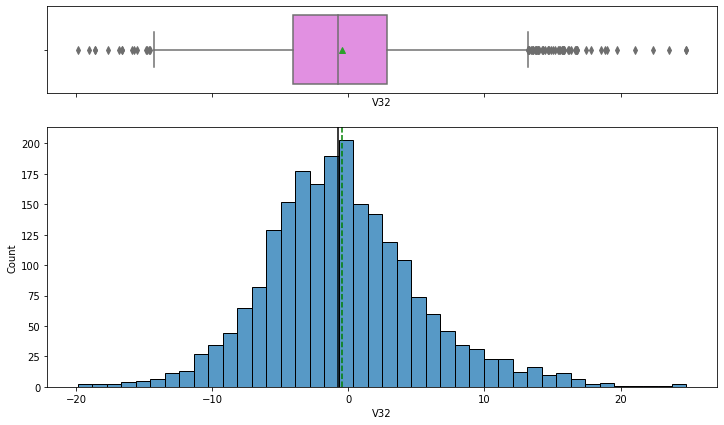

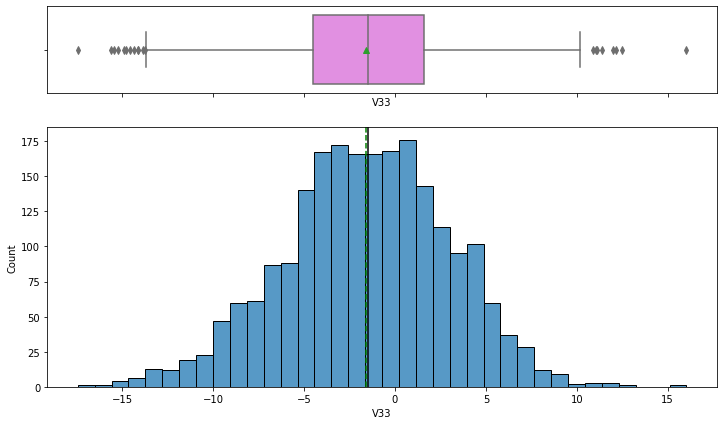

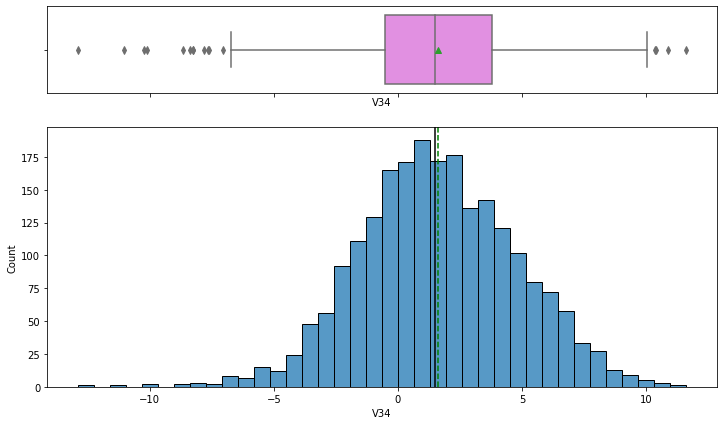

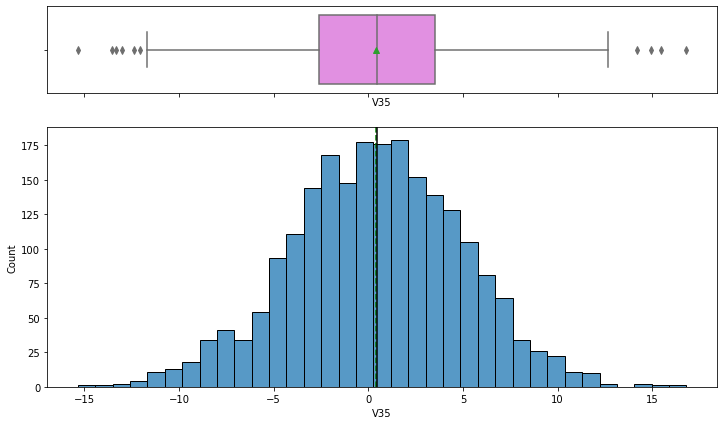

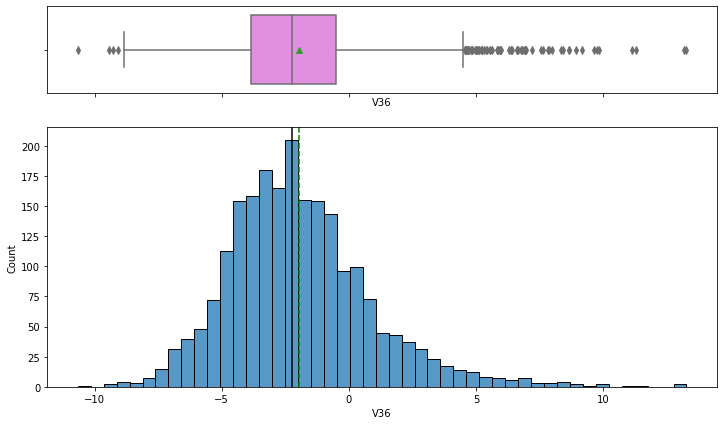

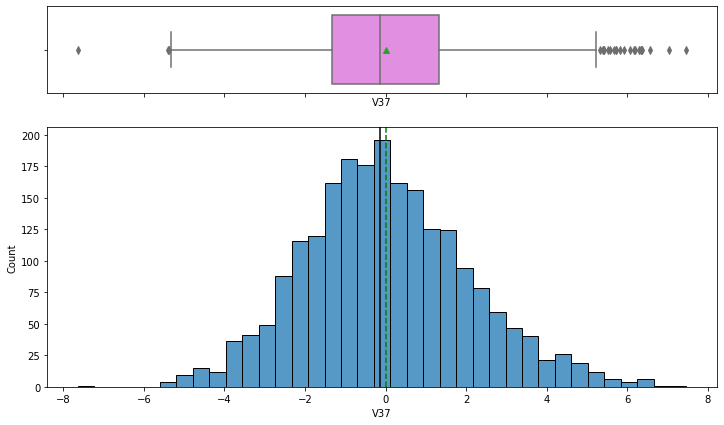

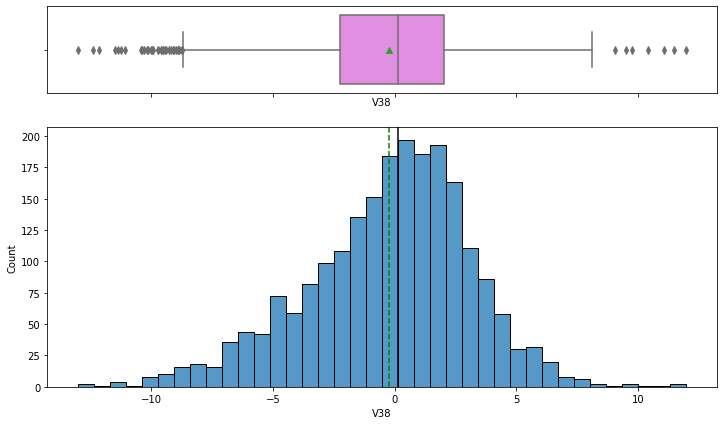

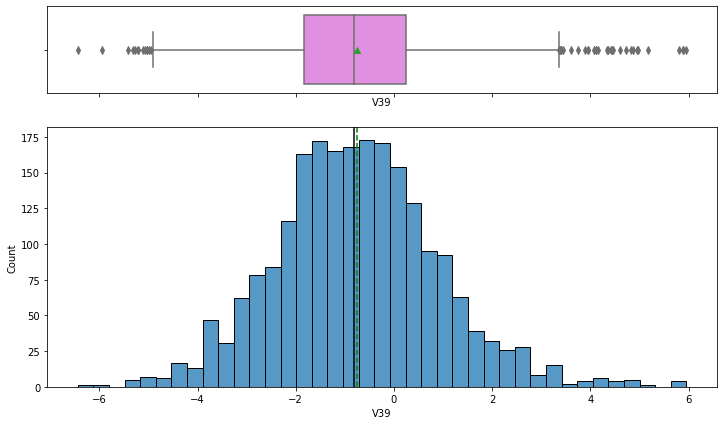

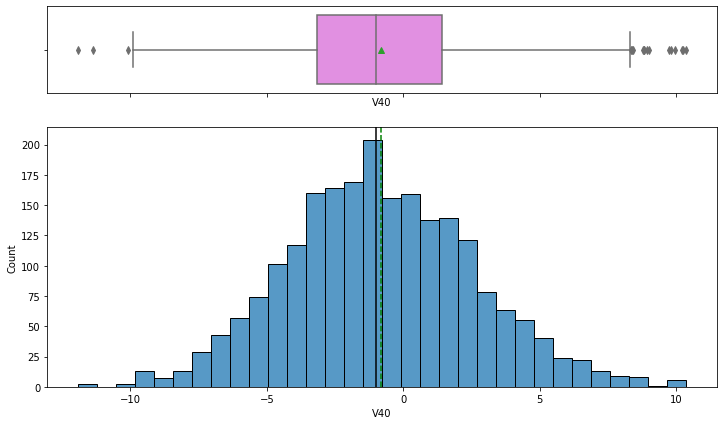

In [18]:
for feature in fail.columns[fail.dtypes=='float64']:
    histogram_boxplot(fail, feature, figsize=(12, 7), kde=False, bins=None)

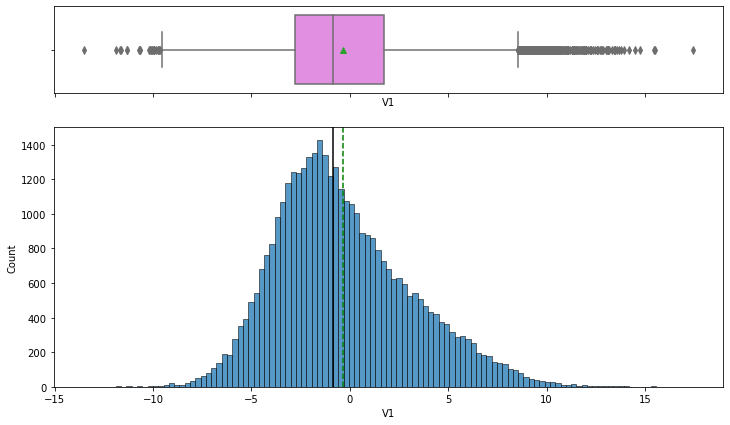

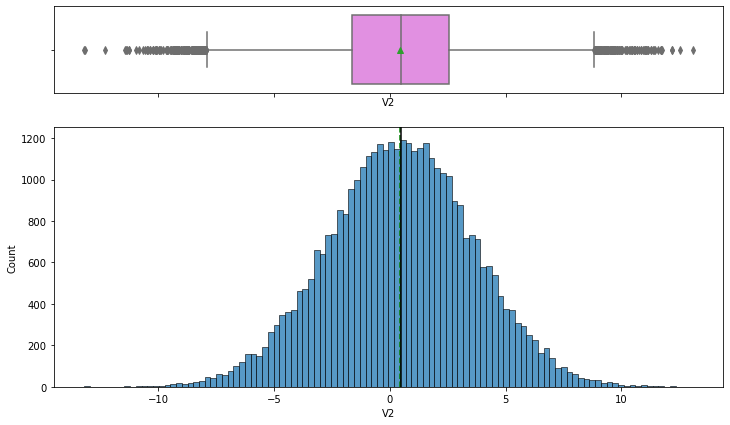

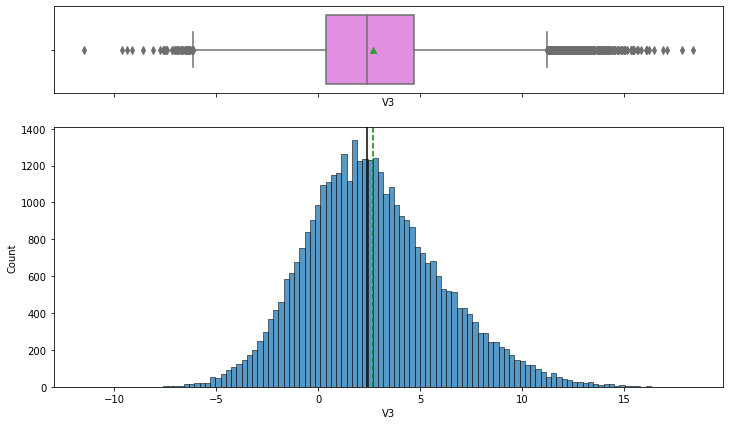

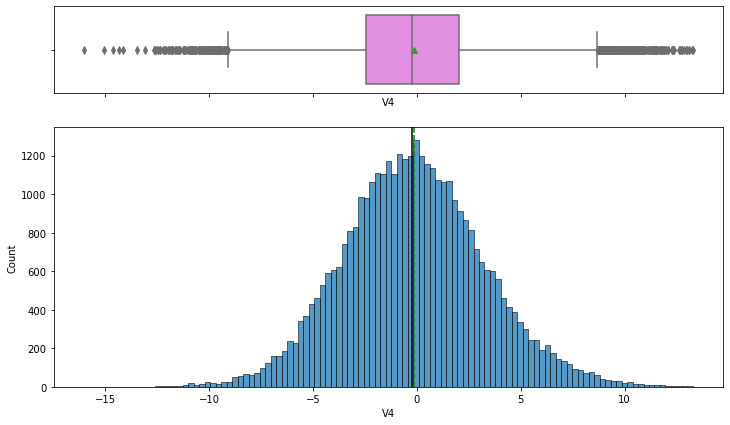

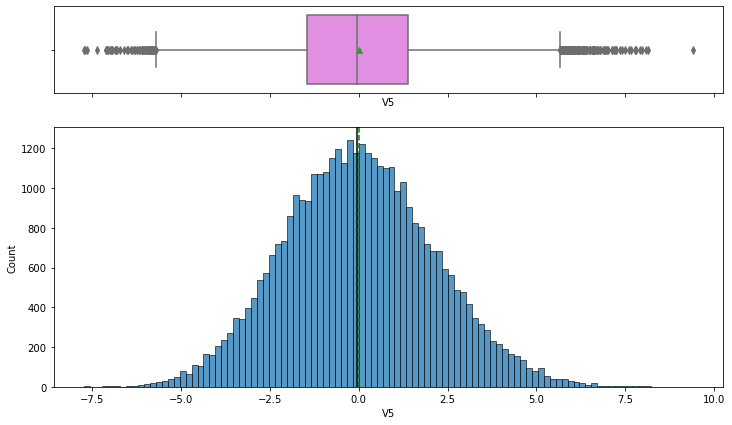

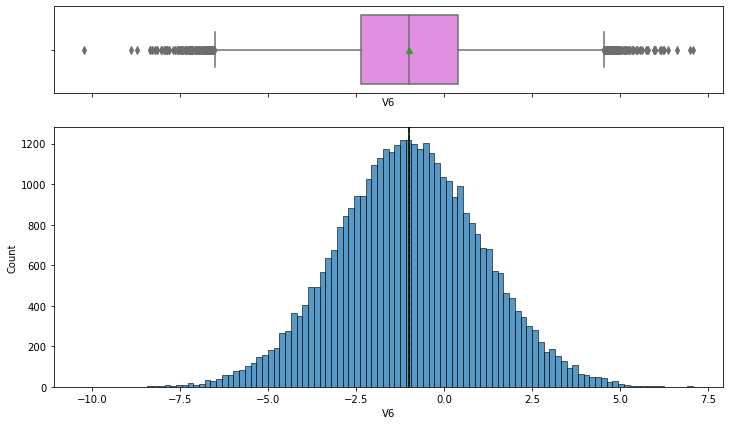

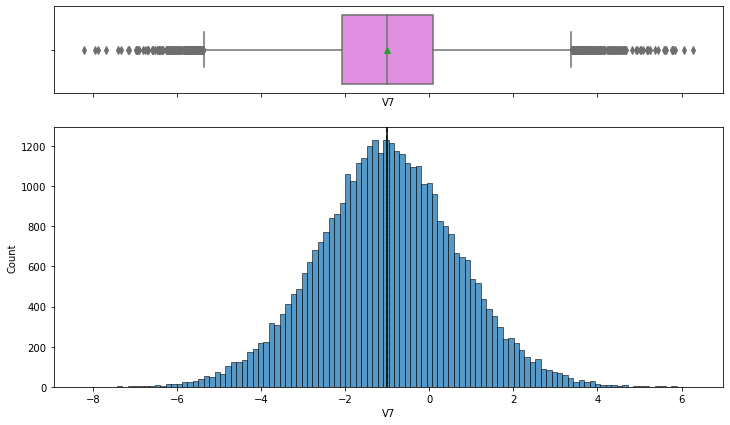

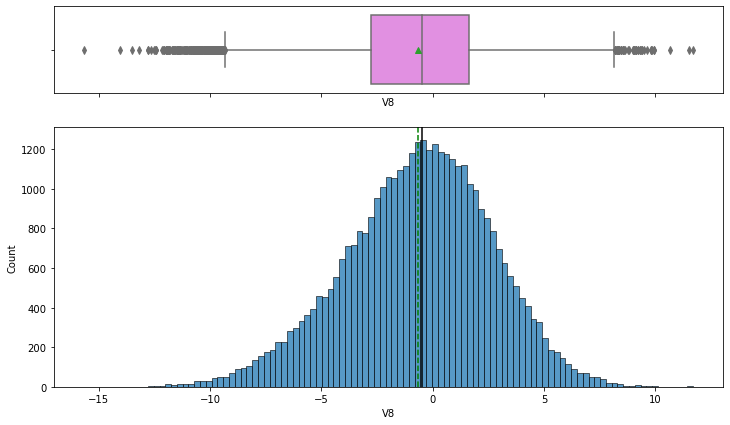

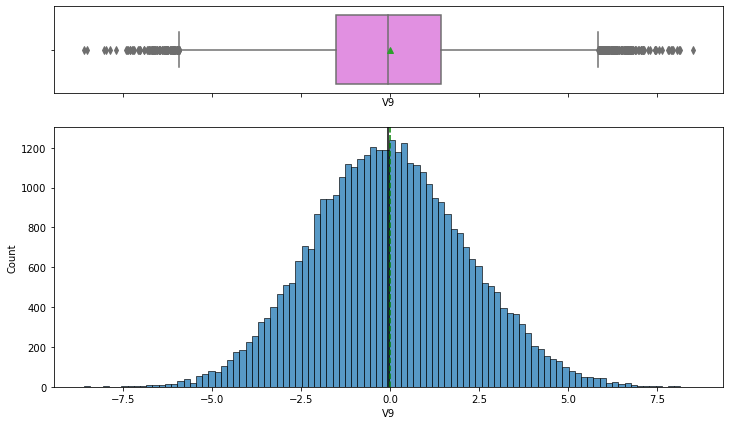

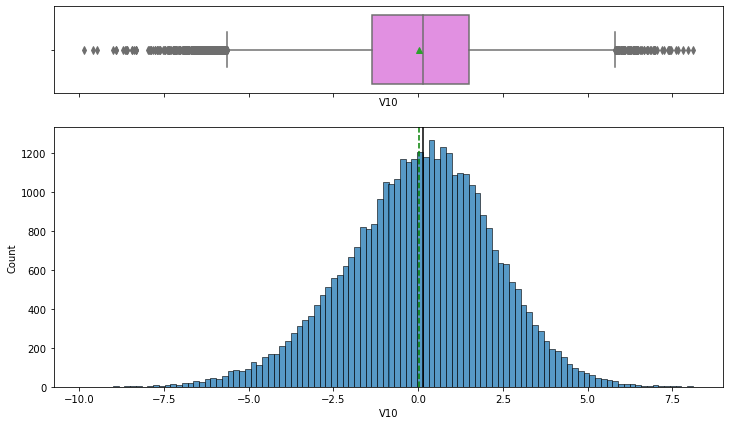

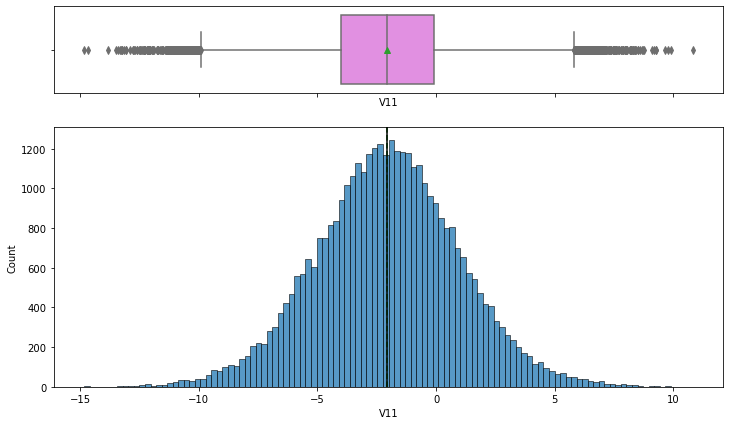

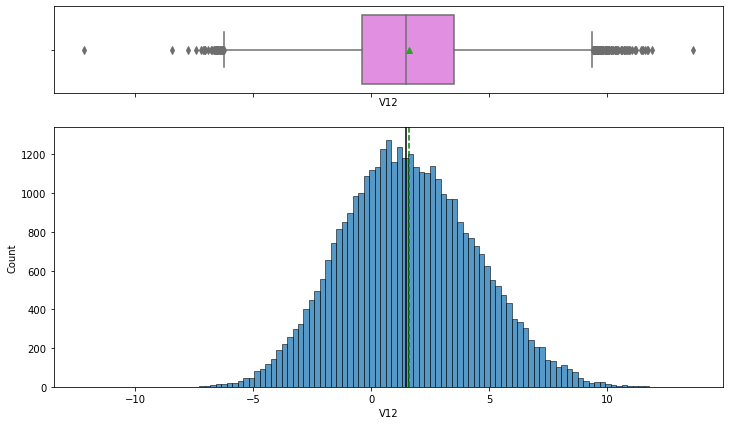

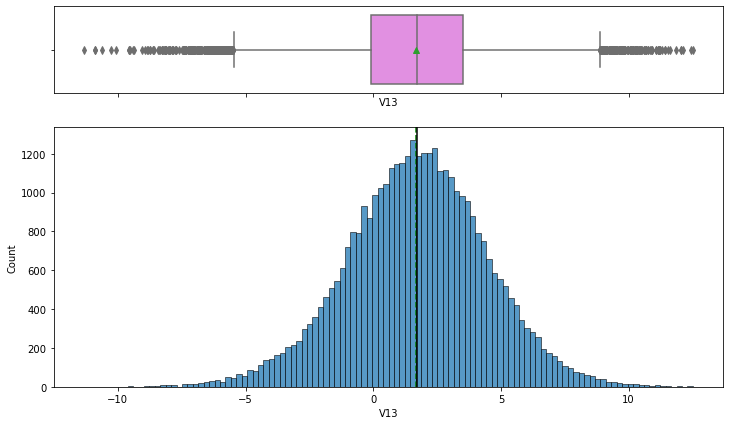

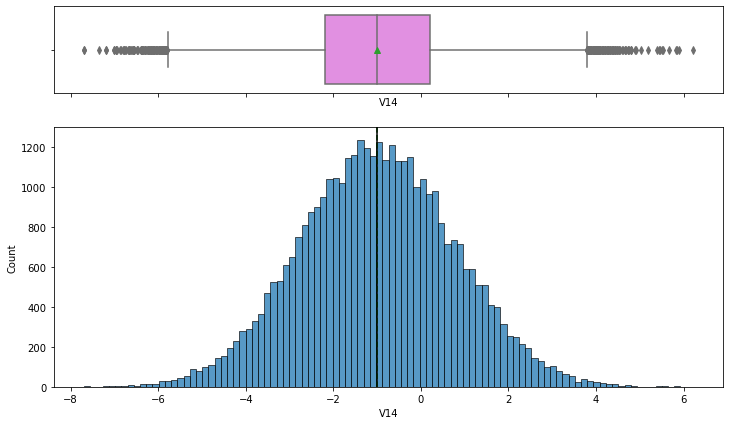

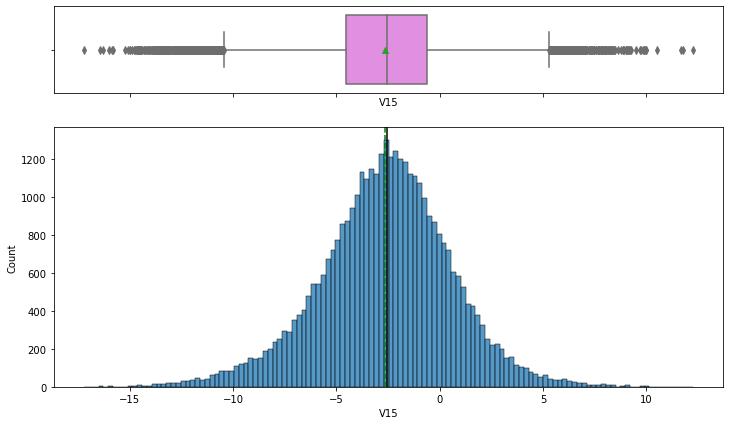

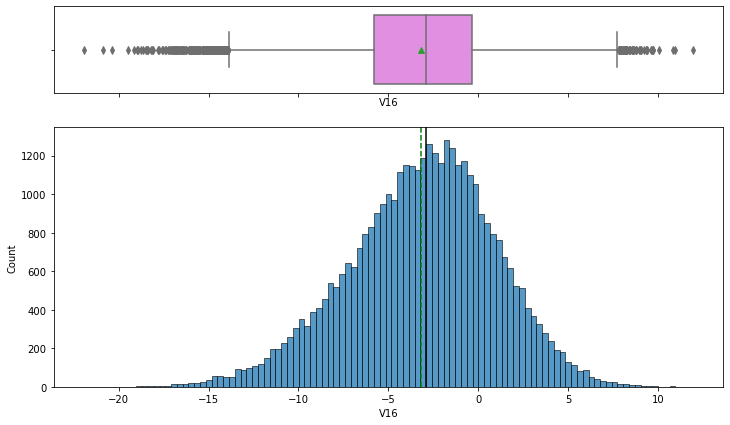

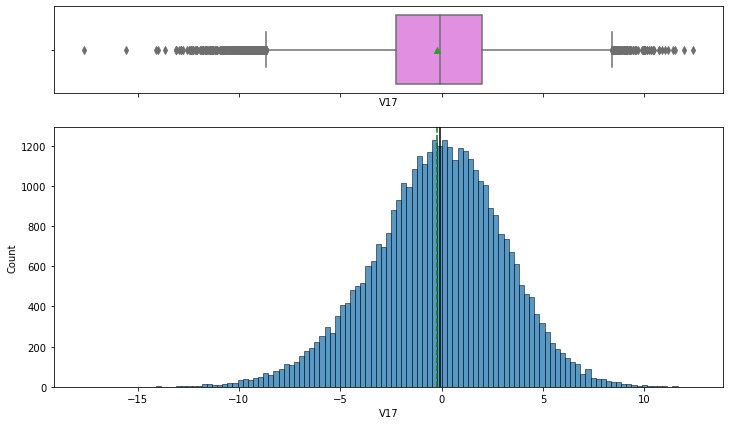

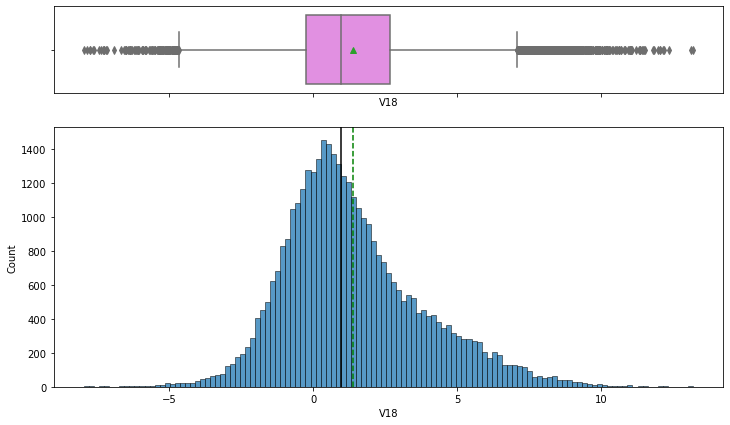

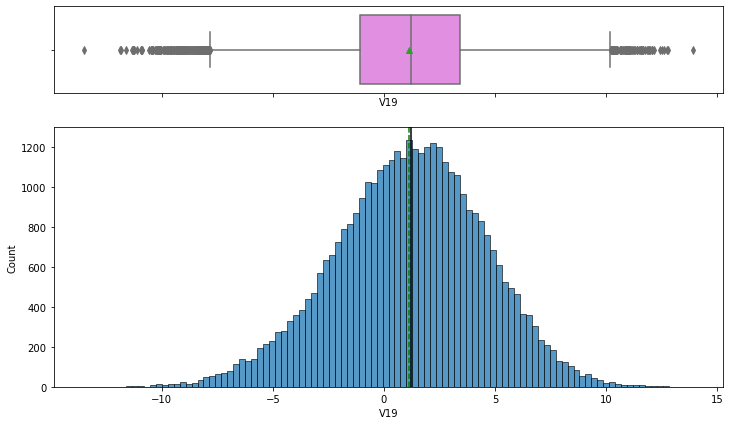

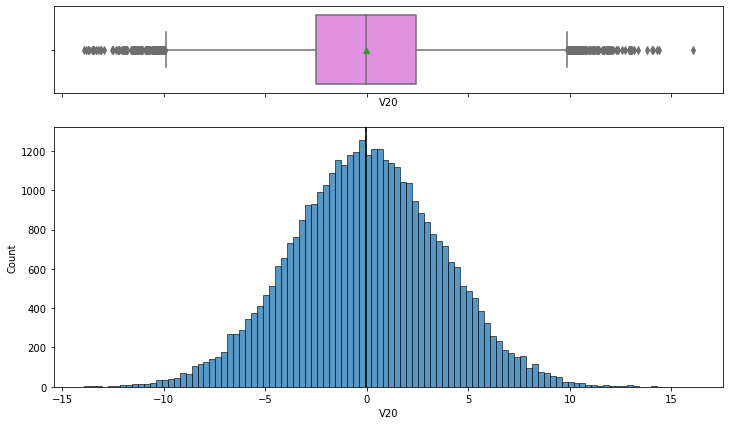

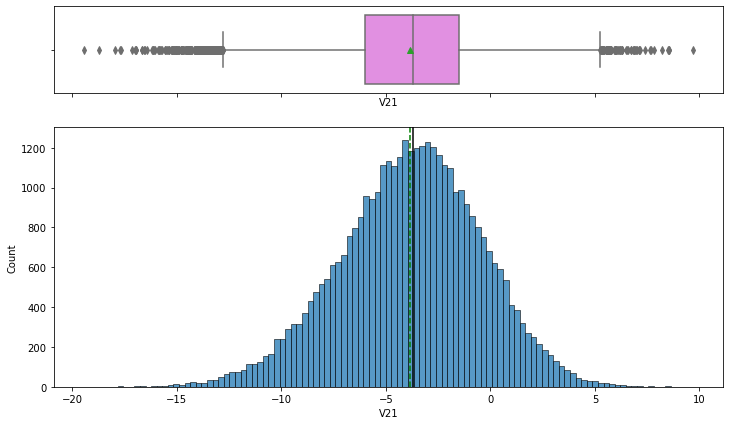

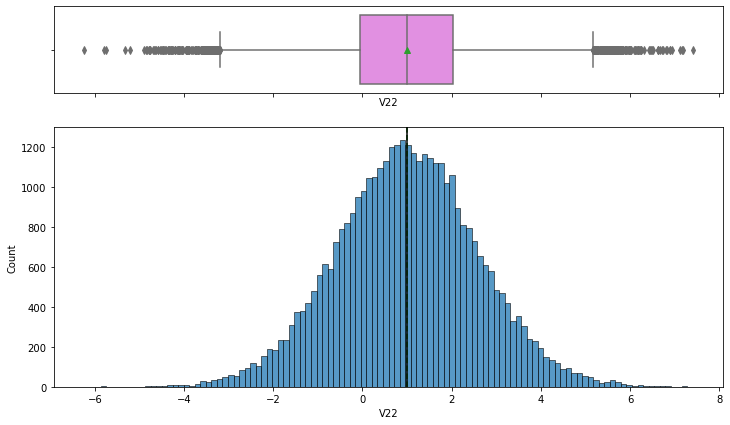

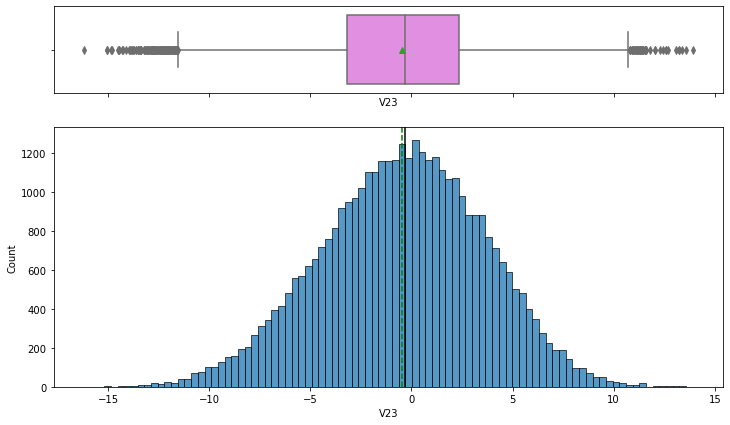

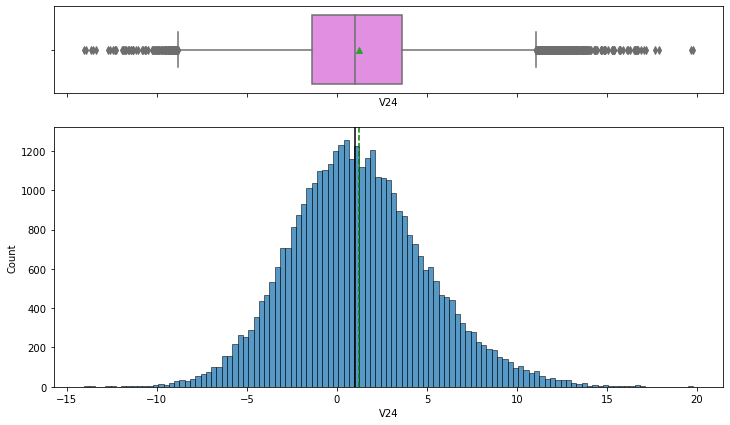

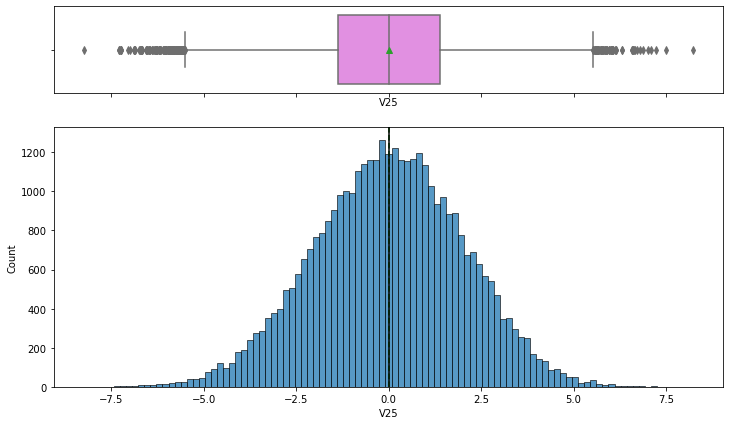

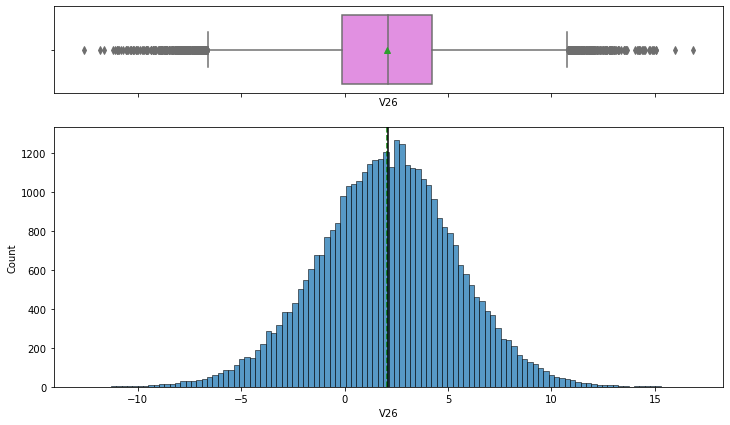

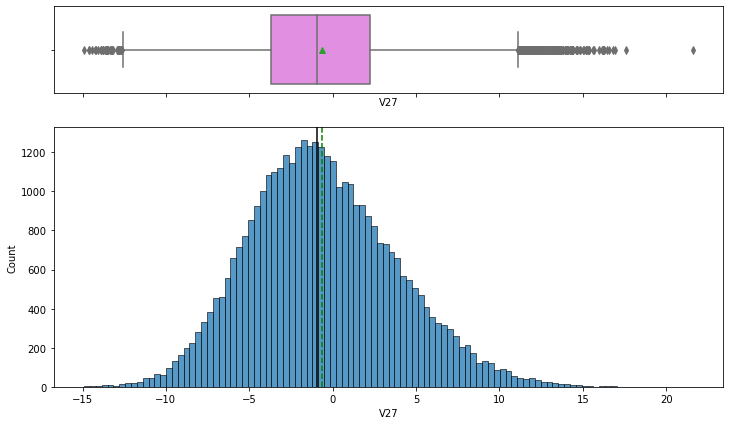

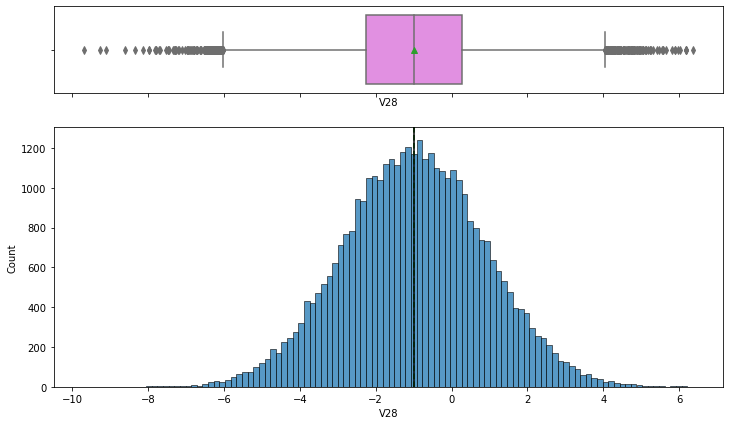

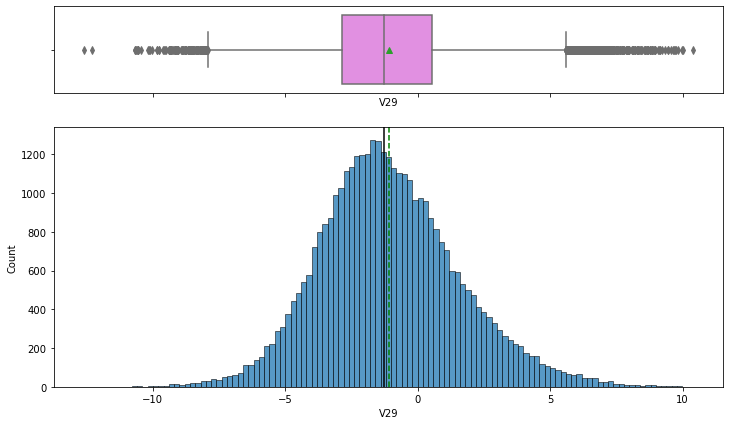

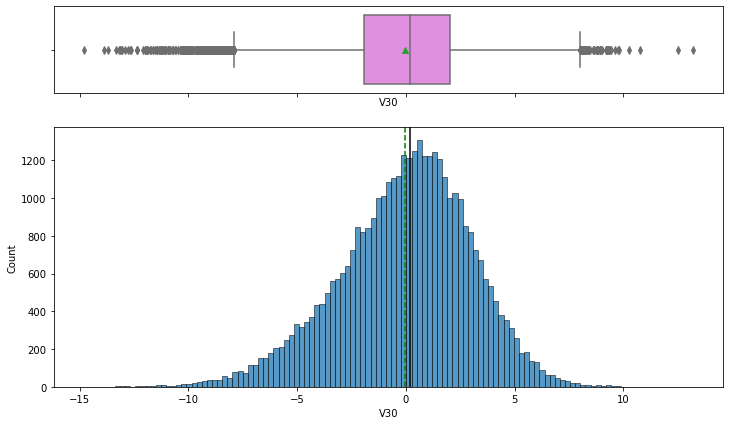

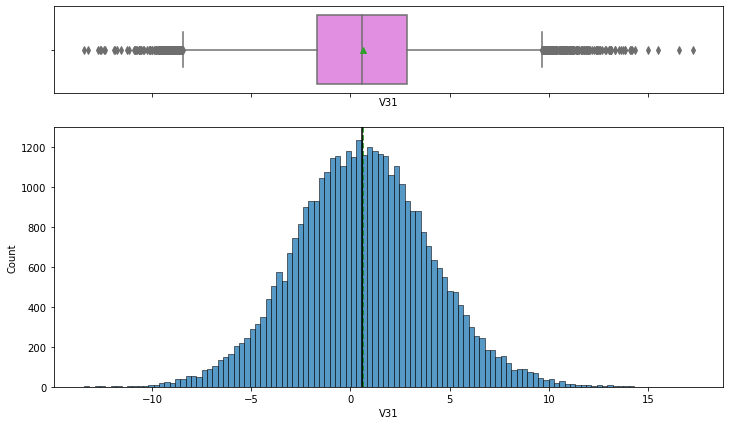

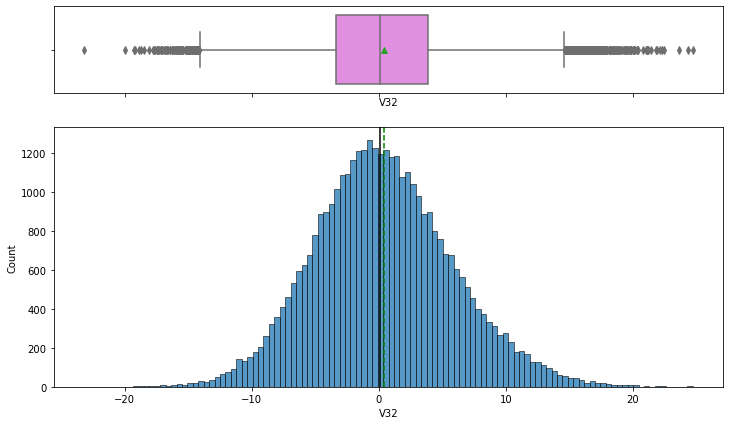

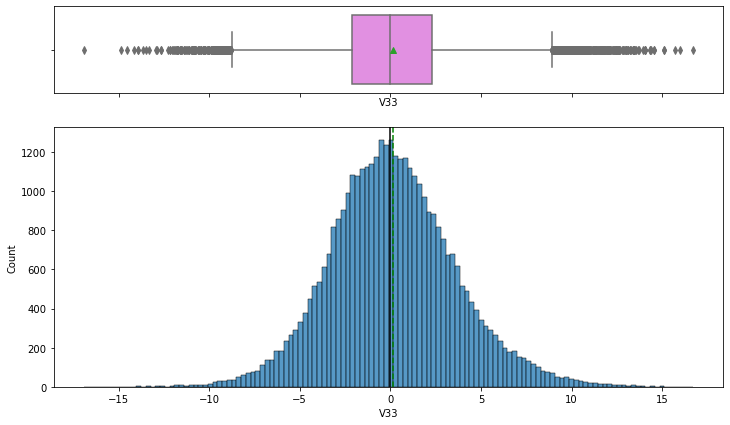

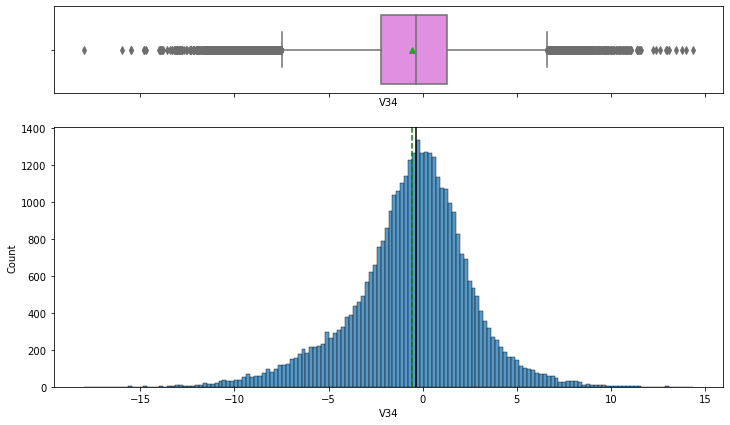

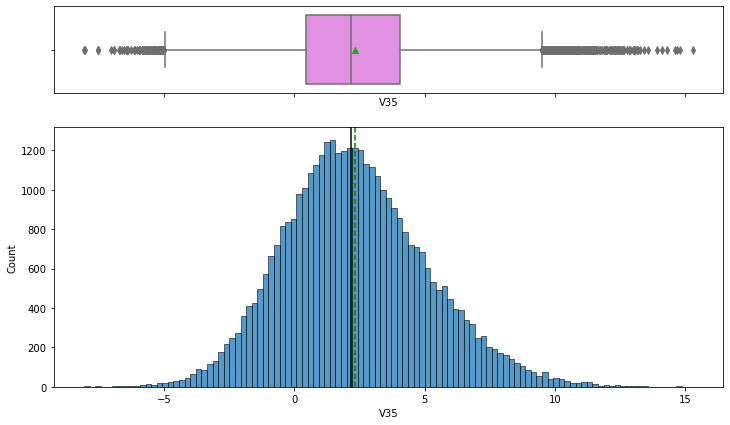

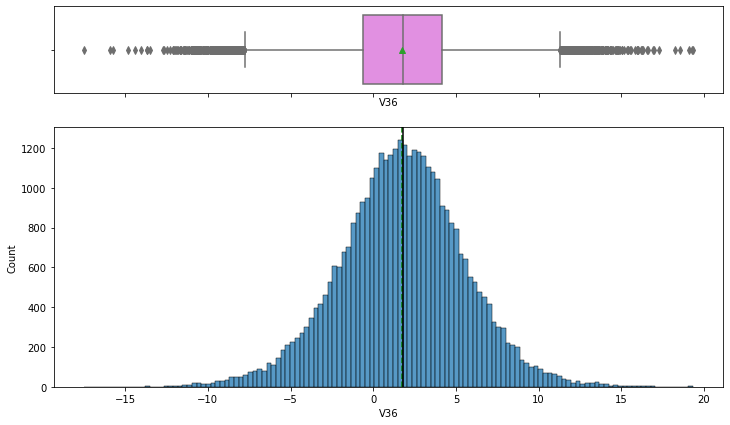

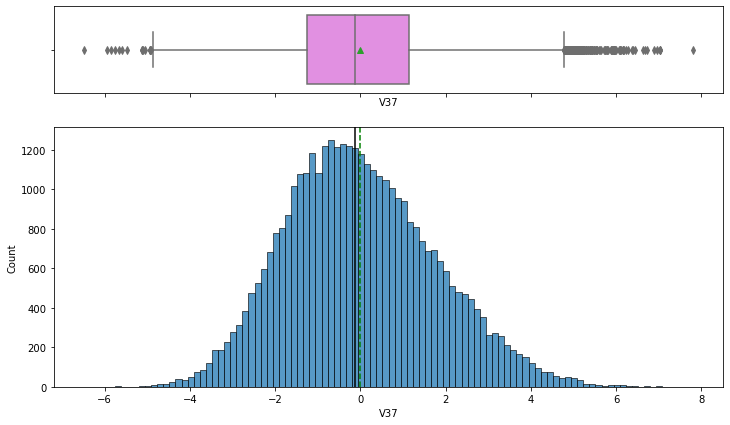

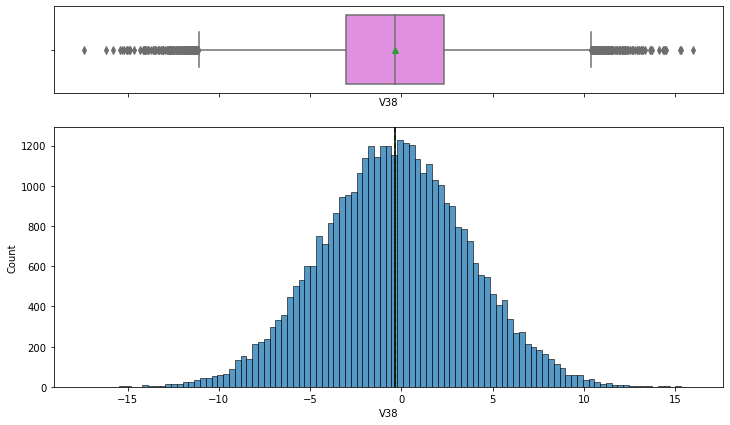

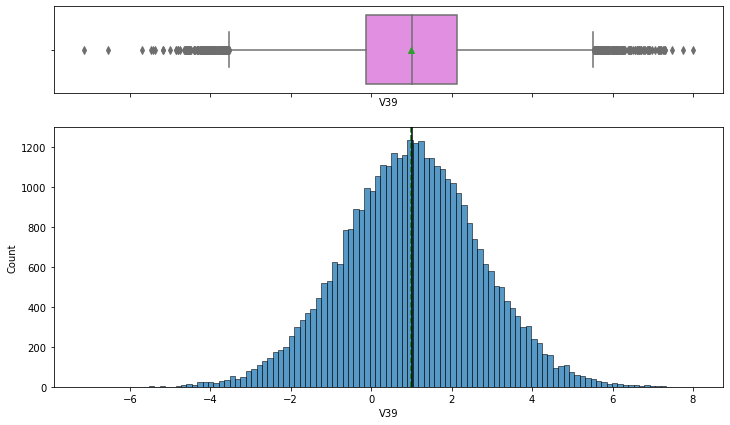

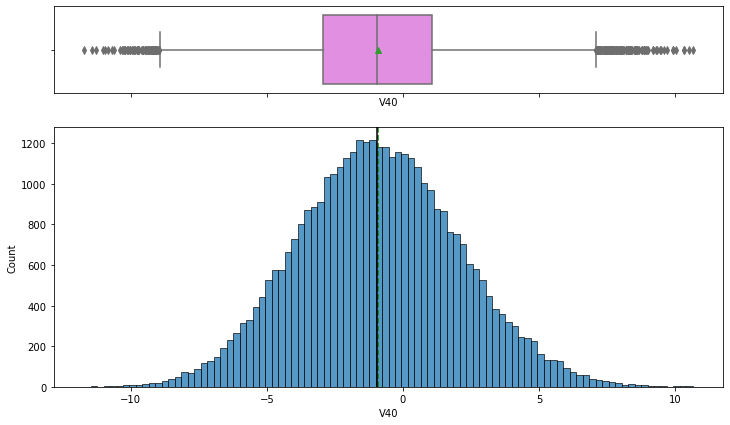

In [19]:
for feature in no_fail.columns[no_fail.dtypes=='float64']:
    histogram_boxplot(no_fail, feature, figsize=(12, 7), kde=False, bins=None)

## Data Pre-processing

In [20]:
# Separating target variable and other variables
X_train = df_train.drop(columns="Target")
Y_train = df_train["Target"]
X_test = df_test.drop(columns="Target")
y_test = df_test["Target"]

In [21]:
# Splitting data into training, validation and test set:
# first we split data into two parts, temporary and test

# then we split the temporary set into train and validation

X_train, X_val, y_train, y_val = train_test_split(
    X_train, Y_train, test_size=0.25, random_state=1, stratify=Y_train
)
print(X_train.shape, X_val.shape, X_test.shape)

(30000, 40) (10000, 40) (10000, 40)


In [22]:
print("Number of rows in train data =", X_train.shape[0])
print("Number of rows in validation data =", X_val.shape[0])
print("Number of rows in test data =", X_test.shape[0])

Number of rows in train data = 30000
Number of rows in validation data = 10000
Number of rows in test data = 10000


In [23]:
# creating an instace of the imputer to be used
imputer = SimpleImputer(strategy="median")

In [24]:
#replace the missing values in the train, validation, and test sets
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(imputer.fit_transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(imputer.fit_transform(X_test), columns=X_test.columns)

In [25]:
#verify there are no missing values in the training data
X_train.isna().sum()

V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64

In [26]:
#verify there are no missing values in the validation data
X_val.isna().sum()

V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64

In [27]:
#verify there are no missing values in the test data
X_test.isna().sum()

V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64

#### Observations
- All dataframes have no missing values

## Model Building

### Model evaluation criterion

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a generator where there is no detection by model. 
- False positives (FP) are failure detections in a generator where there is no failure.

### Which metric to optimize?

* We need to choose the metric which will ensure that the maximum number of generator failures are predicted correctly by the model. ReneWind would thereby be able to repair the identified generator and save 20,000 dollars.
* However, we also need to take into account the 500 dollar cost of inspecting a generator. Hypothetically, where a model to identify too many false positives, the model and ensuing maintenance program may even cost more than ReneWind's current situation.
* Therefore, we our model selection process should optimize for F1 score, which should allow us to select the most profitable model for ReneWind to implement.

**Let's define a function to output different metrics on the train and test set and a function to show confusion matrix so that we do not have to use the same code repetitively while evaluating models.**

In [28]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1
            
        },
        index=[0],
    )

    return df_perf

In [29]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

### Defining scorer to be used for cross-validation and hyperparameter tuning

- To maximize profits, we can use the F1 score as the **scorer** in cross-validation and hyperparameter tuning.

In [30]:
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

### Model Building with original data

In [31]:
%%time

models = []  # Empty list to store all the models

# Appending models into the list
models.append(("dtree", DecisionTreeClassifier(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Cost:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=3, shuffle=True, random_state=1
    )  # Setting number of splits equal to 3
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = f1_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation Cost:

dtree: 0.7218217092576786
Bagging: 0.8197787111724587
Random forest: 0.8580420460119708
GBM: 0.8117295409358608
Adaboost: 0.7125194215509792
Xgboost: 0.8900910009642072

Validation Performance:

dtree: 0.7376014427412083
Bagging: 0.833160621761658
Random forest: 0.8639175257731959
GBM: 0.8171368861024034
Adaboost: 0.7126193001060445
Xgboost: 0.899502487562189
Wall time: 5min 1s


### Model Building with Oversampled data


In [32]:
print("Before Oversampling, counts of label 'Yes': {}".format(sum(y_train == 1)))
print("Before Oversampling, counts of label 'No': {} \n".format(sum(y_train == 0)))

# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

print("After Oversampling, counts of label 'Yes': {}".format(sum(y_train_over == 1)))
print("After Oversampling, counts of label 'No': {} \n".format(sum(y_train_over == 0)))

print("After Oversampling, the shape of X_train: {}".format(X_train_over.shape))
print("After Oversampling, the shape of y_train: {} \n".format(y_train_over.shape))

Before Oversampling, counts of label 'Yes': 1640
Before Oversampling, counts of label 'No': 28360 

After Oversampling, counts of label 'Yes': 28360
After Oversampling, counts of label 'No': 28360 

After Oversampling, the shape of X_train: (56720, 40)
After Oversampling, the shape of y_train: (56720,) 



In [33]:
%%time

models_over = []  # Empty list to store all the models

# Appending models into the list
models_over.append(("dtree", DecisionTreeClassifier(random_state=1)))
models_over.append(("Bagging", BaggingClassifier(random_state=1)))
models_over.append(("Random forest", RandomForestClassifier(random_state=1)))
models_over.append(("GBM", GradientBoostingClassifier(random_state=1)))
models_over.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models_over.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

results1_over = []  # Empty list to store all model's CV scores
names_over = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Cost:" "\n")

for name, model in models_over:
    kfold = StratifiedKFold(
        n_splits=3, shuffle=True, random_state=1
    )  # Setting number of splits equal to 3
    cv_result = cross_val_score(
        estimator=model, X=X_train_over, y=y_train_over, scoring=scorer, cv=kfold
    )
    results1_over.append(cv_result)
    names_over.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models_over:
    model.fit(X_train_over, y_train_over)
    scores = f1_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation Cost:

dtree: 0.9578354942551345
Bagging: 0.9796433419055214
Random forest: 0.9869614424330752
GBM: 0.9394911904324394
Adaboost: 0.9034014211576643
Xgboost: 0.9868417028739912

Validation Performance:

dtree: 0.6453952139231328
Bagging: 0.8502325581395348
Random forest: 0.9125840537944284
GBM: 0.7386973180076628
Adaboost: 0.4957356076759062
Xgboost: 0.8948837209302325
Wall time: 8min 1s


### Model Building with Undersampled data

In [34]:
# Random undersampler for under sampling the data
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

print("Before Undersampling, counts of label 'Yes': {}".format(sum(y_train == 1)))
print("Before Undersampling, counts of label 'No': {} \n".format(sum(y_train == 0)))

print("After Undersampling, counts of label 'Yes': {}".format(sum(y_train_under == 1)))
print("After Undersampling, counts of label 'No': {} \n".format(sum(y_train_under == 0)))

print("After Undersampling, the shape of X_train: {}".format(X_train_under.shape))
print("After Undersampling, the shape of y_train: {} \n".format(y_train_under.shape))

Before Undersampling, counts of label 'Yes': 1640
Before Undersampling, counts of label 'No': 28360 

After Undersampling, counts of label 'Yes': 1640
After Undersampling, counts of label 'No': 1640 

After Undersampling, the shape of X_train: (3280, 40)
After Undersampling, the shape of y_train: (3280,) 



In [35]:
%%time

models_under = []  # Empty list to store all the models

# Appending models into the list
models_under.append(("dtree", DecisionTreeClassifier(random_state=1)))
models_under.append(("Bagging", BaggingClassifier(random_state=1)))
models_under.append(("Random forest", RandomForestClassifier(random_state=1)))
models_under.append(("GBM", GradientBoostingClassifier(random_state=1)))
models_under.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models_under.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

results1_under = []  # Empty list to store all model's CV scores
names_under = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Cost:" "\n")

for name, model in models_under:
    kfold = StratifiedKFold(
        n_splits=3, shuffle=True, random_state=1
    )  # Setting number of splits equal to 3
    cv_result = cross_val_score(
        estimator=model, X=X_train_under, y=y_train_under, scoring=scorer, cv=kfold
    )
    results1_under.append(cv_result)
    names_under.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models_under:
    model.fit(X_train_under, y_train_under)
    scores = f1_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation Cost:

dtree: 0.8527970743102711
Bagging: 0.8994857125634979
Random forest: 0.9261199918073831
GBM: 0.9145955574284502
Adaboost: 0.8772101326618461
Xgboost: 0.9294929552422416

Validation Performance:

dtree: 0.4112725671510348
Bagging: 0.6560111188325226
Random forest: 0.7423312883435583
GBM: 0.6662097326936258
Adaboost: 0.44020474639367146
Xgboost: 0.7596302003081663
Wall time: 20.8 s


#### Observations
- The four best performing models on the validation dataset, ranked from highest to lowest F1 scores, are:
    - Random forest with oversampled data
    - Xgboost with the original data
    - Xgboost with the oversampled data
    - Random forest with the original data

## Hyperparameter Tuning 

### Sample Parameter Grids

**For hyperparameter tuning, we can use the following grids, wherever required.**

- For Gradient Boosting:

param_grid = {
    "n_estimators": np.arange(100,150,25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample":[0.5,0.7], 
    "max_features":[0.5,0.7]
}

- For Adaboost:

param_grid = {
    "n_estimators": [100, 150, 200],
    "learning_rate": [0.2, 0.05],
    "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=2, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1),
    ]
}

- For Bagging Classifier:

param_grid = {
    'max_samples': [0.8,0.9,1], 
    'max_features': [0.7,0.8,0.9],
    'n_estimators' : [30,50,70],
}

- For Random Forest:

param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)
}

- For Decision Trees:

param_grid = {
    'max_depth': np.arange(2,6), 
    'min_samples_leaf': [1, 4, 7],
    'max_leaf_nodes' : [10, 15],
    'min_impurity_decrease': [0.0001,0.001]
}

- For Logistic Regression:

param_grid = {'C': np.arange(0.1,1.1,0.1)}

- For XGBoost:

param_grid={
    'n_estimators': [150, 200, 250],
    'scale_pos_weight': [5,10],
    'learning_rate': [0.1,0.2],
    'gamma': [0,3,5],
    'subsample': [0.8,0.9]
}

### Tuning Random forest with original data

In [36]:
%%time

# defining model
rf = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)
}

#Calling RandomizedSearchCV
rf_tuned = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, 
                              n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
rf_tuned.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(rf_tuned.best_params_, rf_tuned.best_score_))

Best parameters are {'n_estimators': 300, 'min_samples_leaf': 1, 'max_samples': 0.6, 'max_features': 'sqrt'} with CV score=0.852989009291389:
Wall time: 6min 43s


In [37]:
# Creating new pipeline with best parameters
rf_tuned = RandomForestClassifier(
    n_estimators=300, 
    min_samples_leaf=1, 
    max_samples=0.6, 
    max_features='sqrt',
    random_state=1
)

# Fit the model on undersampled training data
rf_tuned.fit(X_train, y_train)

RandomForestClassifier(max_features='sqrt', max_samples=0.6, n_estimators=300,
                       random_state=1)

In [38]:
# Calculating different metrics on train set
rf_grid_train = model_performance_classification_sklearn(
    rf_tuned, X_train, y_train
)
print("Training performance:")
rf_grid_train

Training performance:


,Accuracy,Recall,Precision,F1
0,0.99,0.90,1.00,0.95


In [39]:
# Calculating different metrics on validation set
rf_grid_val = model_performance_classification_sklearn(
    rf_tuned, X_val, y_val
)
print("Validation performance:")
rf_grid_val

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.99,0.75,0.99,0.85


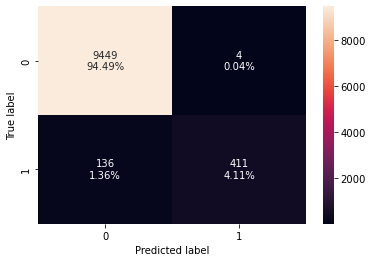

In [40]:
# creating confusion matrix
confusion_matrix_sklearn(rf_tuned, X_val, y_val)

### Tuning Random forest with oversampled data

In [41]:
%%time

# defining model
rf = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)
}

#Calling RandomizedSearchCV
rf_tuned_over = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, 
                              n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
rf_tuned_over.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(rf_tuned_over.best_params_, rf_tuned_over.best_score_))

Best parameters are {'n_estimators': 300, 'min_samples_leaf': 1, 'max_samples': 0.6, 'max_features': 'sqrt'} with CV score=0.9866763765986342:
Wall time: 10min 16s


In [42]:
# Creating new pipeline with best parameters
rf_tuned_over = RandomForestClassifier(
    n_estimators=300, 
    min_samples_leaf=1, 
    max_samples=0.6, 
    max_features='sqrt',
    random_state=1
)

# Fit the model on undersampled training data
rf_tuned_over.fit(X_train_over, y_train_over)

RandomForestClassifier(max_features='sqrt', max_samples=0.6, n_estimators=300,
                       random_state=1)

In [43]:
# Calculating different metrics on train set
rf_grid_train_over = model_performance_classification_sklearn(
    rf_tuned_over, X_train_over, y_train_over
)
print("Training performance:")
rf_grid_train_over

Training performance:


,Accuracy,Recall,Precision,F1
0,1.00,1.00,1.00,1.00


In [44]:
# Calculating different metrics on validation set
rf_grid_val_over = model_performance_classification_sklearn(
    rf_tuned_over, X_val, y_val
)
print("Validation performance:")
rf_grid_val_over

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.99,0.87,0.95,0.91


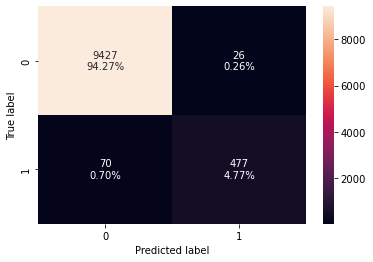

In [45]:
# creating confusion matrix
confusion_matrix_sklearn(rf_tuned_over, X_val, y_val)

### Tuning Xgboost with original data

In [46]:
%%time

# defining model
xb = XGBClassifier(random_state=1,eval_metric="logloss")

# Parameter grid to pass in RandomSearchCV
param_grid={
    'n_estimators': [150, 200, 250],
    'scale_pos_weight': [5,10],
    'learning_rate': [0.1,0.2],
    'gamma': [0,3,5],
    'subsample': [0.8,0.9]
}

#Calling RandomizedSearchCV
xb_tuned = RandomizedSearchCV(estimator=xb, param_distributions=param_grid, n_iter=10, 
                              n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
xb_tuned.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(xb_tuned.best_params_,xb_tuned.best_score_))

Best parameters are {'subsample': 0.9, 'scale_pos_weight': 10, 'n_estimators': 200, 'learning_rate': 0.2, 'gamma': 0} with CV score=0.9073849468844963:
Wall time: 13min 56s


In [47]:
# Creating new pipeline with best parameters
xb_tuned = XGBClassifier(
    subsample=0.9, 
    scale_pos_weight=10, 
    n_estimators=200, 
    learning_rate=0.2, 
    gamma=0,
    eval_metric="logloss",
    random_state=1
)

# Fit the model on undersampled training data
xb_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=10, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [48]:
# Calculating different metrics on train set
xb_grid_train = model_performance_classification_sklearn(
    xb_tuned, X_train, y_train
)
print("Training performance:")
xb_grid_train

Training performance:


,Accuracy,Recall,Precision,F1
0,1.00,1.00,1.00,1.00


In [49]:
# Calculating different metrics on validation set
xb_grid_val = model_performance_classification_sklearn(
    xb_tuned, X_val, y_val
)
print("Validation performance:")
xb_grid_val

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.99,0.87,0.97,0.92


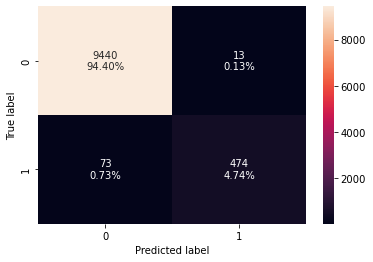

In [50]:
# creating confusion matrix
confusion_matrix_sklearn(xb_tuned, X_val, y_val)

### Tuning Xgboost with oversampled data

In [51]:
%%time

# defining model
xb = XGBClassifier(random_state=1,eval_metric="logloss")

# Parameter grid to pass in RandomSearchCV
param_grid={
    'n_estimators': [150, 200, 250],
    'scale_pos_weight': [5,10],
    'learning_rate': [0.1,0.2],
    'gamma': [0,3,5],
    'subsample': [0.8,0.9]
}

#Calling RandomizedSearchCV
xb_tuned_over = RandomizedSearchCV(estimator=xb, param_distributions=param_grid, n_iter=10, 
                              n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
xb_tuned_over.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(xb_tuned_over.best_params_,xb_tuned_over.best_score_))

Best parameters are {'subsample': 0.9, 'scale_pos_weight': 10, 'n_estimators': 200, 'learning_rate': 0.2, 'gamma': 0} with CV score=0.9908034558005822:
Wall time: 27min 24s


In [52]:
# Creating new pipeline with best parameters
xb_tuned_over = XGBClassifier(
    subsample=0.9, 
    scale_pos_weight=10, 
    n_estimators=200, 
    learning_rate=0.2, 
    gamma=0,
    eval_metric="logloss",
    random_state=1
)

# Fit the model on undersampled training data
xb_tuned_over.fit(X_train_over, y_train_over)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=10, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [53]:
# Calculating different metrics on train set
xb_grid_train_over = model_performance_classification_sklearn(
    xb_tuned_over, X_train_over, y_train_over
)
print("Training performance:")
xb_grid_train_over

Training performance:


,Accuracy,Recall,Precision,F1
0,1.00,1.00,1.00,1.00


In [54]:
# Calculating different metrics on validation set
xb_grid_val_over = model_performance_classification_sklearn(
    xb_tuned_over, X_val, y_val
)
print("Validation performance:")
xb_grid_val_over

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.98,0.89,0.84,0.86


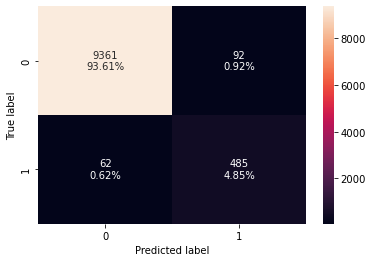

In [55]:
# creating confusion matrix
confusion_matrix_sklearn(xb_tuned_over, X_val, y_val)

## Model Performance Comparison


In [56]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        rf_grid_train.T,
        rf_grid_train_over.T,
        xb_grid_train.T,
        xb_grid_train_over.T
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Random forest with original data",
    "Random forest with oversampled data",
    "Xgboost with original data",
    "Xgboost with oversampled data"
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Random forest with original data,Random forest with oversampled data,Xgboost with original data,Xgboost with oversampled data
Accuracy,0.99,1.00,1.00,1.00
Recall,0.90,1.00,1.00,1.00
Precision,1.00,1.00,1.00,1.00
F1,0.95,1.00,1.00,1.00


In [57]:
# validation performance comparison

models_val_comp_df = pd.concat(
    [
        rf_grid_val.T,
        rf_grid_val_over.T,
        xb_grid_val.T,
        xb_grid_val_over.T
    ],
    axis=1,
)
models_val_comp_df.columns = [
    "Random forest with original data",
    "Random forest with oversampled data",
    "Xgboost with original data",
    "Xgboost with oversampled data"
]
print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


,Random forest with original data,Random forest with oversampled data,Xgboost with original data,Xgboost with oversampled data
Accuracy,0.99,0.99,0.99,0.98
Recall,0.75,0.87,0.87,0.89
Precision,0.99,0.95,0.97,0.84
F1,0.85,0.91,0.92,0.86


- The two best perfoming tuned models, ranked by F1 score, are:
    - Random Forest with oversampled data
    - Xgboost with original data

- Now, we can calculate the predicted savings ReneWind should be able to realize through a prevenatative maintenance model
- As a reminder, the costs for ReneWind are as follows:
    - Replacement cost = 40,000 dollars
    - Repair cost = 15,000 dollars
    - Inspection cost = 5,000 dollars

In [58]:
# display counts of failures and non-failures in validation dataset
y_val.value_counts()

0    9453
1     547
Name: Target, dtype: int64

In [59]:
# calculate the predicted costs without a model
pred_cost_without = 40000*len(y_val[y_val==1])
print("The predicted cost to ReneWind without the model is $"+"{:,}".format(pred_cost_without))

The predicted cost to ReneWind without the model is $21,880,000


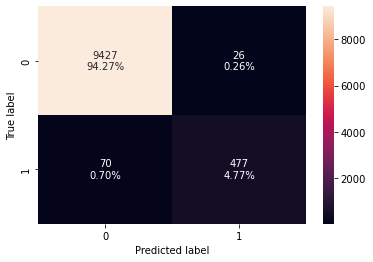

In [60]:
# confusion matrix for the Random Forest model with oversampled data
confusion_matrix_sklearn(rf_tuned_over, X_val, y_val)

In [61]:
# calculate the predicted costs using the above confusion matrix from the Random Forest model
pred_cost_with_xb = 40000*70+(5000+15000)*477+5000*26
print("The predicted cost to ReneWind with the Xgboost preventative maintenance model is $"
      +"{:,}".format(pred_cost_with_xb))

The predicted cost to ReneWind with the Xgboost preventative maintenance model is $12,470,000


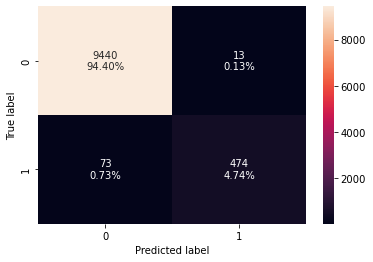

In [62]:
# confusion matrix for the Xgboost model with original data
confusion_matrix_sklearn(xb_tuned, X_val, y_val)

In [63]:
# calculate the predicted cost using the above confusion matrix from the Xgboost model
pred_cost_with_rf = 40000*73+(5000+15000)*474+5000*13
print("The predicted cost to ReneWind with the Random Forest preventative maintenance model is $"
      +"{:,}".format(pred_cost_with_rf))

The predicted cost to ReneWind with the Random Forest preventative maintenance model is $12,465,000


In [64]:
# calculate the predicted cost difference for the Random Forest model
pred_cost_savings_rf = pred_cost_without-pred_cost_with_rf
print("The predicted cost savings to ReneWind with the Random Forest model is expected to be $"
      +"{:,}".format(pred_cost_savings_rf))

The predicted cost savings to ReneWind with the Random Forest model is expected to be $9,415,000


In [65]:
# calculate the predicted cost difference for the Xgboost model
pred_cost_savings_xb = pred_cost_without-pred_cost_with_xb
print("The predicted cost savings to ReneWind with the Xgboost model is expected to be $"
      +"{:,}".format(pred_cost_savings_xb))

The predicted cost savings to ReneWind with the Xgboost model is expected to be $9,410,000


#### Observations
- After accounting for the various costs provided by ReneWind for each model, the Random Forest model created with the oversampled dataset should realize the most cost savings

### Test set final performance

In [66]:
# Calculating different metrics on validation set
rf_tuned_test_perf = model_performance_classification_sklearn(
    rf_tuned_over, X_test, y_test
)
print("Test performance:")
rf_tuned_test_perf

Test performance:


,Accuracy,Recall,Precision,F1
0,0.99,0.85,0.95,0.90


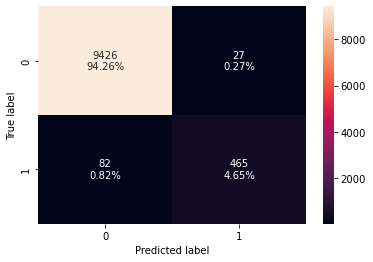

In [67]:
# creating confusion matrix
confusion_matrix_sklearn(rf_tuned_over, X_test, y_test)

In [68]:
# calculate the cost without the model
act_cost_without = 40000*len(y_test[y_test==1])
print("The actual cost to ReneWind without the model would have been $"+"{:,}".format(act_cost_without))

The actual cost to ReneWind without the model would have been $21,880,000


In [69]:
# calculate the actual cost using the above confusion matrix from the Random Forest model
act_cost_with = 40000*82+(5000+15000)*465+5000*27
print("The actual cost for ReneWind after implementing the preventative maintenance model would have been $"
      +"{:,}".format(act_cost_with))

The actual cost for ReneWind after implementing the preventative maintenance model would have been $12,715,000


In [70]:
# calculate the actual cost difference
act_cost_savings = act_cost_without-act_cost_with
print("The predicted cost savings for implementing the model and preventative maintenance program was $"
      +"{:,}".format(pred_cost_savings_rf))
print("The actual cost savings were $"+"{:,}".format(act_cost_savings)+", an overall cost reduction of "+
      str(round(act_cost_savings/act_cost_without,3)*100)+"%")

The predicted cost savings for implementing the model and preventative maintenance program was $9,415,000
The actual cost savings were $9,165,000, a overall cost reduction of 41.9%


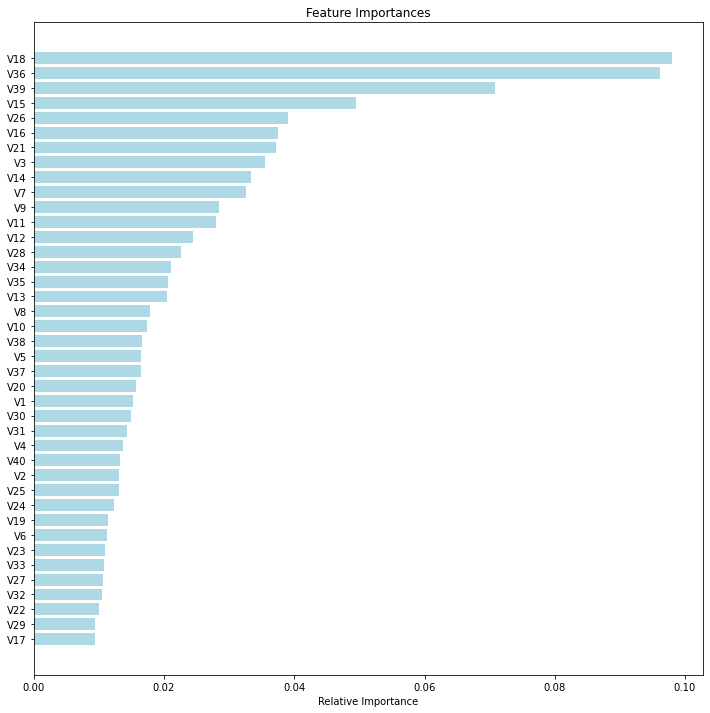

In [71]:
# show the most important features (i.e., columns) from the tuned Random Forest model, ranked from highest to lowest
feature_names = X_test.columns
importances = rf_tuned_over.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="lightblue", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

- The top three most important sensors for predicting a generator failure are V18, V36, and V39
- Again, ReneWind would benefit from further analyzing the root causes of why these sensors contribute the most to us being able to predict whether a generator while fail or not

## Final Model Pipeline

In [72]:
"""create a pipeline that fills the missing values in a dataset, followed by the Random Forest model 
with the hyperparameters tuned from the oversampled data above"""
pipeline = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy="median")),
    ("RF", rf_tuned_over)])

In [73]:
# Separating target variable from the other variables for both the training and test datasets
X1_train = df_train.drop(columns="Target")
y1_train = df_train["Target"]

X1_test = df_test.drop(columns="Target")
y1_test = df_test["Target"]

In [74]:
# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X1_train_over, y1_train_over = sm.fit_resample(X_train, y_train)

In [75]:
# fit the oversampled training data to the Random Forest model
pipeline.fit(X1_train_over,y1_train_over)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('RF',
                 RandomForestClassifier(max_features='sqrt', max_samples=0.6,
                                        n_estimators=300, random_state=1))])

In [76]:
# use the pipeline to predict the failed generators within the testing data
pipeline.predict(X1_test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

## Conclusions

- Due to the encryption of the sensor data, we are unable to provide as rich an expoloratory data analysis as we would have preferred, but there are a few insights we can pass along for ReneWind to research further:
    - Compare the distributions and summary statistics of the sensors for generators that fail and do not fail
        - This may provide evidence that there are operational, engineering, or some other root causes which the company could use to reduct failures across its wind turbines
    - The top three most important sensors for predicting a generator failure are V18, V36, and V39

- The Random Forest model built from oversampled data provided the highest F1 score across both the validation and testing data and performed similarly well on both, leading us to the conclusion that this model should generalize well in production

- By utilizing the model we've provided as part of a preventative maintenance program, ReneWind can reasonably expect the company to be able to reduce the amount spent on maintaining its fleet of generators by over **40%**